In [1]:
#importing all the required libraries

import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import pickle

# Undistorting the images
Read all the input images for calibrating the camera images.

In [2]:
def read_calib_images():
    input_images = glob.glob('camera_cal/*.jpg')
    calib_imgs = []

    for file in input_images:
        img = mpimg.imread(file)
        calib_imgs.append(img)
        
    return calib_imgs

def read_test_images():
    input_images = glob.glob('test_images/*.jpg')
    test_imgs = []

    for file in input_images:
        img = mpimg.imread(file)
        test_imgs.append(img)
        
    return test_imgs


Function to find corners in chess board, and seperate the images in which the corners cannot be detected

In [3]:
def find_corners(imgs, no_x, no_y):
    points_3D = [] 
    points_2D = [] 
    
    corners_not_detected = [] 
    corners_detected = [] 
    
    obj_3D = np.zeros((no_x * no_y, 3), np.float32)
    obj_3D[:,:2] = np.mgrid[0:no_x, 0:no_y].T.reshape(-1, 2)
    
    for img in imgs:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray_img, (no_x, no_y), None)
        
        if ret == True:
            points_3D.append(obj_3D)
            points_2D.append(corners)
            corners_detected.append(img)
        else:
            corners_not_detected.append(img)
            
    return points_3D, points_2D, corners_detected, corners_not_detected

Testing the functionality of Corners detected and not detected in the list of input images

Number of images in which corners were detected =  17
Number of images in which corners were not detected =  3

images of corners detected


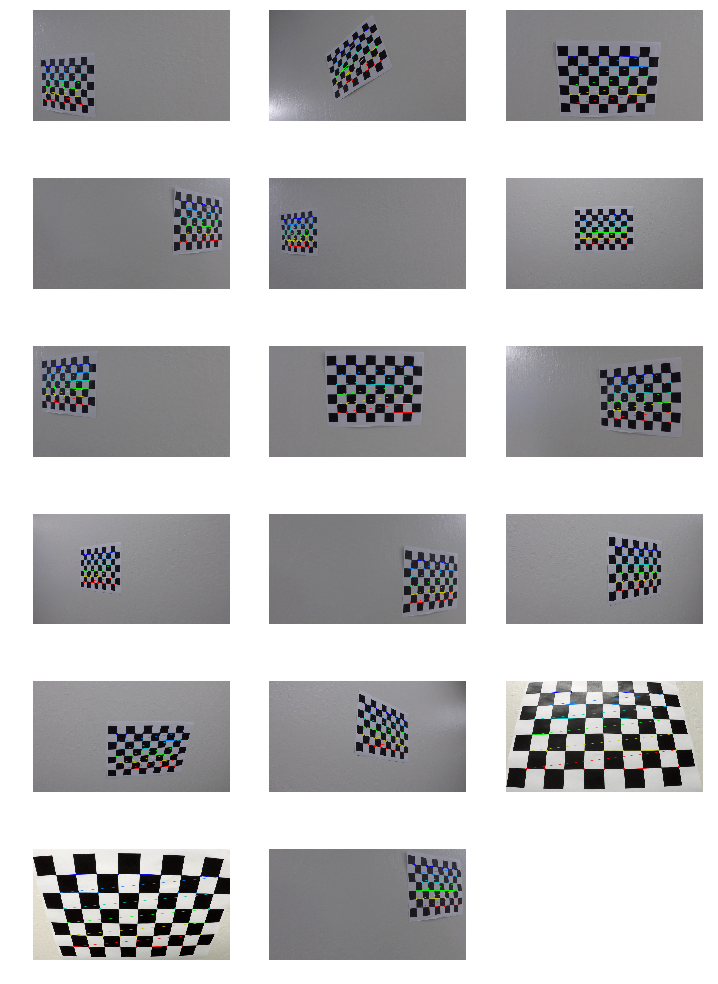


images of corners not detected


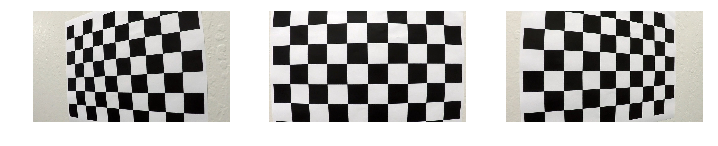

In [4]:
#Number of corners to be found
no_x = 9
no_y = 6

calib_imgs = read_calib_images()
points_3D, points_2D, corners_detected, corners_not_detected = find_corners(calib_imgs, no_x, no_y)

print("Number of images in which corners were detected = ", len(corners_detected))
print("Number of images in which corners were not detected = ", len(corners_not_detected))

# view the images
print("")
print("images of corners detected")
plt.figure(figsize=(12, 18))
for idx, img in enumerate(corners_detected):
    cv2.drawChessboardCorners(img, (no_x, no_y), points_2D[idx], True)
    plt.subplot(6, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')    
plt.show()

print("")
print("images of corners not detected")
plt.figure(figsize=(12, 3))
for idx, img in enumerate(corners_not_detected):
    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')    
plt.show()



Since the number of x and y corners to be detected is more than the number of corners that could be observed in the previous 3 images, it is classified as not detected

Function to undistort an image

In [5]:
def get_calibration_value(img, points_3D, points_2D):
    
    img_shape = (img.shape[0], img.shape[1])
    
    #calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(points_3D, points_2D, img_shape, None, None)
    return mtx, dist

def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

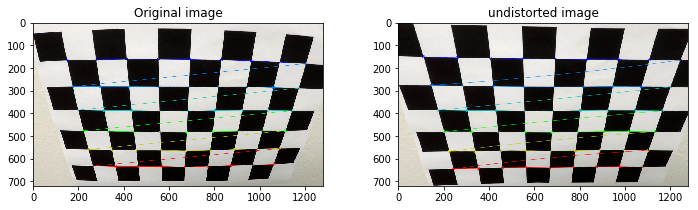

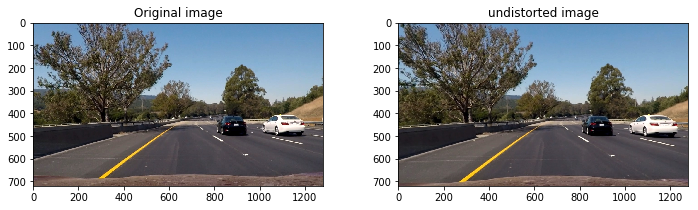

In [6]:
mtx, dist = get_calibration_value(corners_detected[0], points_3D, points_2D)

calibration_value = {}
calibration_value["mtx"] = mtx
calibration_value["dist"] = dist
pickle.dump( calibration_value, open( "calibration_value.p", "wb" ) )
img =corners_detected[15]
undist_img = undistort_img(img, mtx, dist)

plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("undistorted image")
plt.imshow(undist_img)
plt.savefig("output_images/chessboard.png")
plt.show()

test_imgs = read_test_images()
test_img = test_imgs[3]
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.title("undistorted image")
plt.imshow(undistort_img(test_img, mtx, dist))
plt.savefig("output_images/road.png")
plt.show()

# Pipeline for lane detection
Convert the images to binary format

In [7]:
def convert_to_binary(img, sobel_thresh=(25,255), satu_thresh=(125, 255), light_thresh=(125,255)):
    
    raw_img = np.copy(img)
    
    # Convert to HLS color space and separate the H channel
    hls = cv2.cvtColor(raw_img, cv2.COLOR_RGB2HLS).astype(np.float)
    light_channel = hls[:,:,1]
    satu_channel = hls[:,:,2]
    
    # Sobel x
    sobel_x = cv2.Sobel(light_channel, cv2.CV_64F, 1, 0) 
    abs_sobel_x = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    
    # x gradient thresholding
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    # Lightness channel thresholding
    light_binary = np.zeros_like(light_channel)
    light_binary[(light_channel >= light_thresh[0]) & (light_channel <= light_thresh[1])] = 1
    
    # Saturation channel thresholding
    satu_binary = np.zeros_like(satu_channel)
    satu_binary[(satu_channel >= satu_thresh[0]) & (satu_channel <= satu_thresh[1])] = 1
    
    binary = np.zeros_like(sx_binary)
    binary[((light_binary == 1) & (satu_binary == 1) | (sx_binary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return binary

Testing the binary functionality

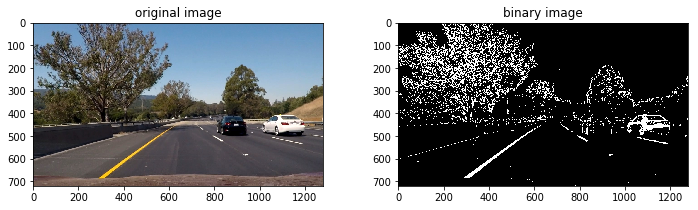

In [8]:

binary = convert_to_binary(test_img)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(binary)
plt.title("binary image")
plt.savefig("output_images/thresholded_image.png")
plt.show()

Warping the images

In [9]:
# depending on the requirement of top view or camera view, warp the image
def img_warp(img, top_view=True):
    
    src = np.float32(
        [[120, 720],
         [580, 450],
         [750, 450],
         [1160, 720]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])
    img_shape = (img.shape[1], img.shape[0])
    
    if top_view:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
        
    warped_img = cv2.warpPerspective(img, M, img_shape, flags=cv2.INTER_LINEAR)
    
    return warped_img

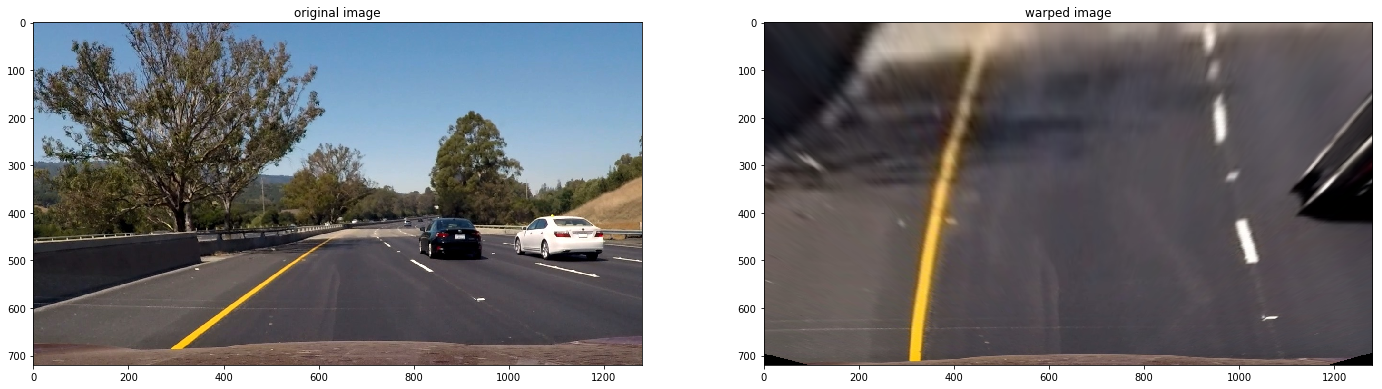

In [10]:

with open('calibration_value.p', mode='rb') as f:
    calibration_value = pickle.load(f)
    mtx = calibration_value["mtx"]
    dist = calibration_value["dist"]

undist_img = undistort_img(test_img, mtx, dist)
warped_img = img_warp(undist_img)
plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(1,2,2)
plt.imshow(warped_img)
plt.title("warped image")
plt.savefig("output_images/warped_image.png")
plt.show()

In [11]:
def img_msk(img):
    points = np.array([[(0,img.shape[0]),(580, 450), (750, 450), (img.shape[1],img.shape[0])]], dtype=np.int32)
    msk = np.zeros_like(img)
    
    no_of_channels = img.shape[2]
    msk_color = (255, ) * no_of_channels
    
    cv2.fillPoly(msk, points, msk_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, msk)
    return masked_image

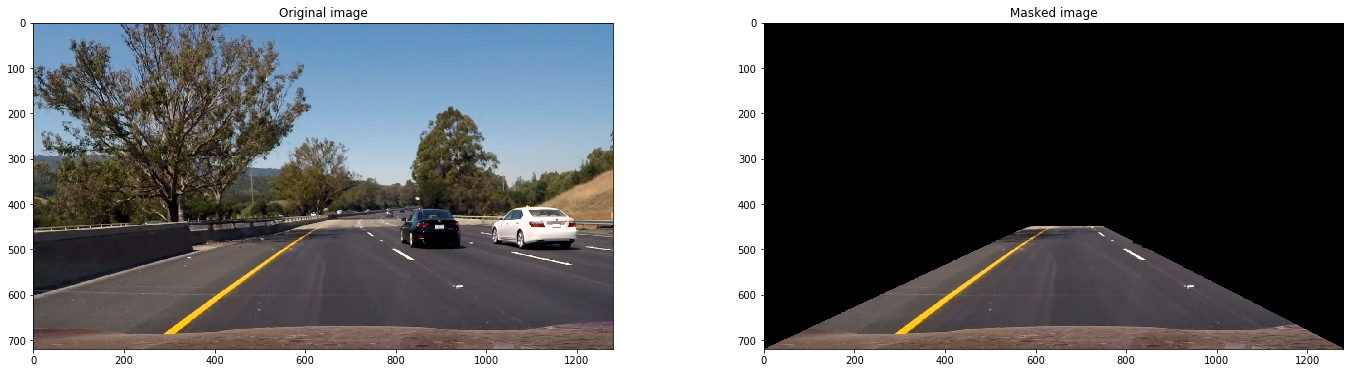

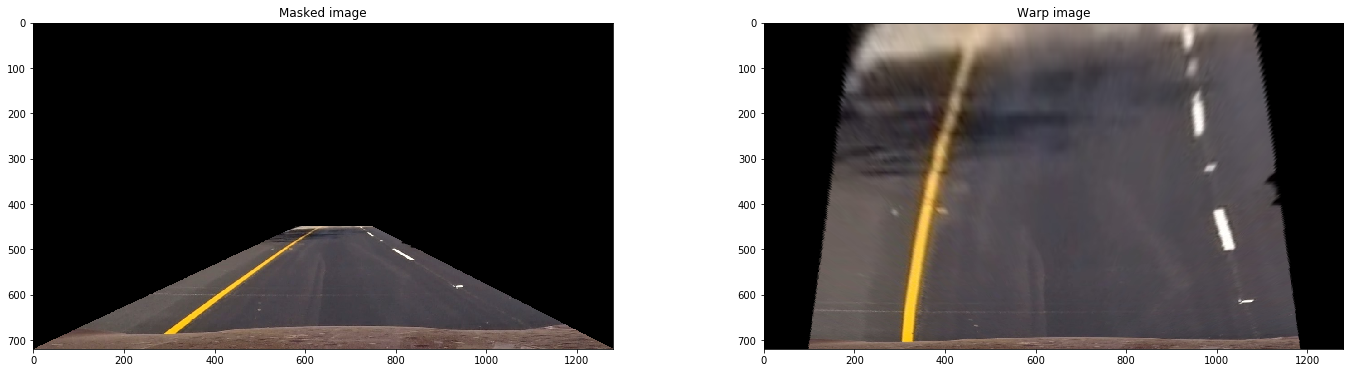

In [12]:
msk_img = img_msk(test_img)
warp_img = img_warp(msk_img)
plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(test_imgs[3])
plt.subplot(1,2,2)
plt.imshow(msk_img)
plt.title("Masked image")
plt.savefig("output_images/masked_image.png")
plt.show()

plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.imshow(msk_img)
plt.title("Masked image")
plt.subplot(1,2,2)
plt.imshow(warp_img)
plt.title("Warp image")
plt.savefig("output_images/mask_warp_image.png")
plt.show()


Pipeline functionality

In [13]:
def warp_pipe(img, mtx, dist):
    undist_img = undistort_img(img, mtx, dist)
    bin_img = convert_to_binary(undist_img)
    msked_img = img_msk(bin_img)
    warp_img = img_warp(msked_img)
    
    return warp_img

Testing the warp pipeline

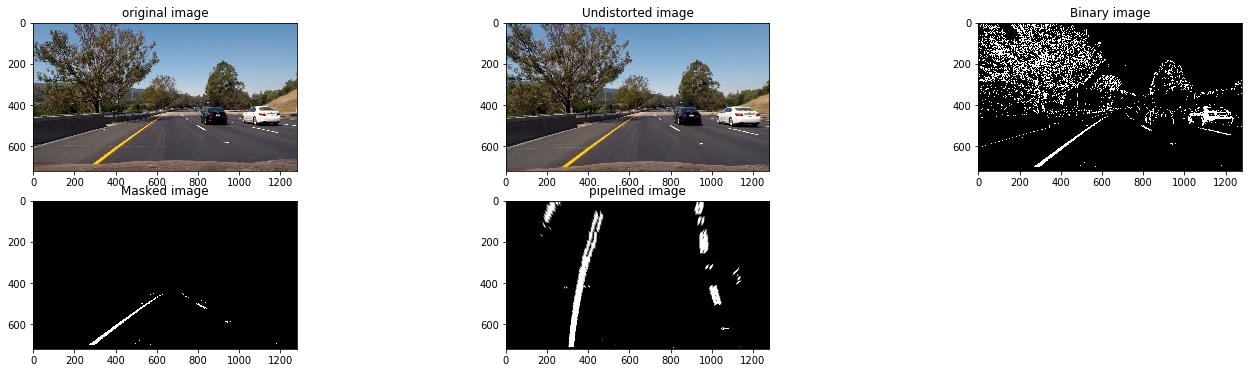

In [14]:
pipelined_img = warp_pipe(test_img, mtx, dist)
bin_img = convert_to_binary(undist_img)
msk_img = img_msk(bin_img)

plt.figure(figsize=(24,6))
plt.subplot(2,3,1)
plt.title("original image")
plt.imshow(test_img)
plt.subplot(2,3,2)
plt.title("Undistorted image")
plt.imshow(undist_img)
plt.subplot(2,3,3)
plt.title("Binary image")
plt.imshow(bin_img)
plt.subplot(2,3,4)
plt.title("Masked image")
plt.imshow(msk_img)
plt.subplot(2,3,5)
plt.title("pipelined image")
plt.imshow(pipelined_img)
plt.savefig("output_images/pipeline.png")
plt.show()

In [15]:
def histogram_peaks(img):
    mid_point = img[img.shape[0] // 2 :, :]
    histogram = np.sum(mid_point, axis=0)
    return histogram
    
def sliding_window(img):
    hist = histogram_peaks(img)
    
    mid = np.int(hist.shape[0] // 2)
    left_x_base = np.argmax(hist[:mid])
    right_x_base = np.argmax(hist[mid:]) + mid
    
    nwindows = 10
    window_height = np.int(img.shape[0]/nwindows)
    
    nonzero = img.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
   
    left_x_current = left_x_base
    right_x_current = right_x_base
    
    margin = 80
    minpix = 40
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = left_x_current - margin
        win_xleft_high = left_x_current + margin
        win_xright_low = right_x_current - margin
        win_xright_high = right_x_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xleft_low) & (nonzero_x < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_xright_low) & (nonzero_x < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            left_x_current = np.int(np.mean(nonzero_x[good_left_inds]))
        if len(good_right_inds) > minpix:        
            right_x_current = np.int(np.mean(nonzero_x[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds] 
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, (leftx, lefty), (rightx, righty)


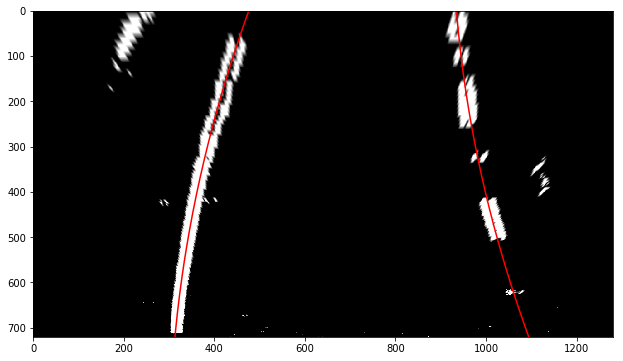

In [16]:
msk_bin_img = pipelined_img[:, :, 0]
plt.figure(figsize=(24,6))
left_fit, right_fit, left_ind, right_ind = sliding_window(msk_bin_img)
x = test_img.shape[0]

left_fit_x_int = left_fit[0]*x**2 + left_fit[1]*x + left_fit[2]
right_fit_x_int = right_fit[0]*x**2 + right_fit[1]*x + right_fit[2]

out_img = np.uint8(np.dstack((msk_bin_img, msk_bin_img, msk_bin_img))*255)
ploty = np.linspace(0, msk_bin_img.shape[0]-1, msk_bin_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
nonzero = msk_bin_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
plt.imshow(pipelined_img)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig("output_images/polyfit.png")
plt.show()

Draw lane onto the original image

In [17]:
def draw_lane(org_img, msk_bin_img, left_fit, right_fit):
    
    new_img = np.copy(org_img)
    # if there is no left and right fit then return the original image
    if left_fit is None or right_fit is None:
        return original_img
    
    # An image of the shape of original image to draw the lane and overlay on top of original image
    warp_zero = np.zeros_like(msk_bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    y,x = msk_bin_img.shape
    ploty = np.linspace(0, y-1, num=y)
    left_fit = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # stack x and y coodinates, which can be used in fill poly function
    pts_left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,255,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,0), thickness=15)

    # Warp the blank back to original image space
    inv_warp = img_warp(color_warp, top_view=False) 
    
    # Combine the lane image with the original image
    result = cv2.addWeighted(new_img, 1, inv_warp, 0.25, 0)
    return result, ploty
    

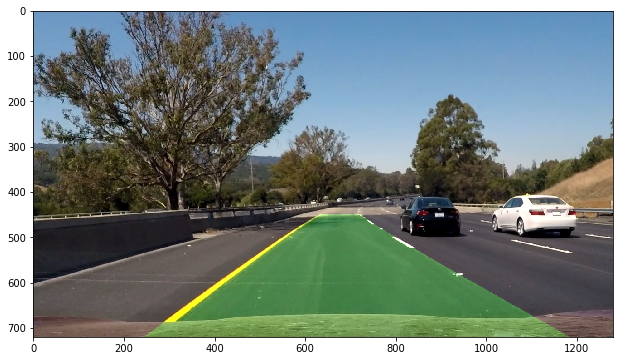

In [18]:
lane_img, ploty = draw_lane(test_img, msk_bin_img, left_fit, right_fit)
plt.figure(figsize=(12,6))
plt.imshow(lane_img)
plt.savefig("output_images/lane_image.png")
plt.show()

Calculation of Radius of curvature

In [24]:
def radius_of_curvature(ploty, left_lane_inds, right_lane_inds, img_shape):
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    y_met_per_pix = 30 / 720 # meters per pixel in y dimension
    x_met_per_pix = 3.7 / 700 # meters per pixel in x dimension

    # Extract left and right line pixel positions
    leftx = left_lane_inds[0]
    lefty = left_lane_inds[1] 
    rightx = right_lane_inds[0]
    righty = right_lane_inds[1]
    
    # Fit new polynomials to x,y in world space
    left_fit = np.polyfit(lefty * y_met_per_pix, leftx * x_met_per_pix, 2)
    right_fit = np.polyfit(righty * y_met_per_pix, rightx * x_met_per_pix, 2)
    
    # Calculate radius of curvature
    left_curve_radians = ((1 + (2 * left_fit[0] * y_eval * y_met_per_pix + left_fit[1]) ** 2) ** 1.5) \
                        / np.absolute(2 * left_fit[0])
    right_curve_radians = ((1 + (2 * right_fit[0] * y_eval * y_met_per_pix + right_fit[1]) ** 2) ** 1.5) \
                        / np.absolute(2 * right_fit[0])
    print(left_curve_radians, right_curve_radians)
    radius = round(np.mean([left_curve_radians, right_curve_radians]), 0) / 1000
    radius_text = "Radius of Curvature = {} km".format(round(radius, 4))
    
    # Calculating middle of the image, aka where the car camera is
    mid_img = img_shape[1] / 2
    car_pos = mid_img * x_met_per_pix
    
    # To calculate distance from center, Finds the base of the line at the bottom of the image.
    y = img_shape[0] * y_met_per_pix
    left_base_line = (left_fit[0] * y **2) + (left_fit[1] * y) + left_fit[2]
    right_base_line = (right_fit[0] * y **2) + (right_fit[1] * y) + right_fit[2]
    mid = (left_base_line + right_base_line) / 2
    dev_from_center = (mid - car_pos) * 100
    
    if dev_from_center >= 0:
        dev_text = "Car is {} cm left of center".format(round(dev_from_center, 4))
    else:
        dev_text = "Car is {} cm right of center".format(round(dev_from_center, 4))
        
    
    return radius_text, dev_text

884.196826595 847.980609713
Radius of Curvature = 0.866 km
Car is 33.6403 cm left of center


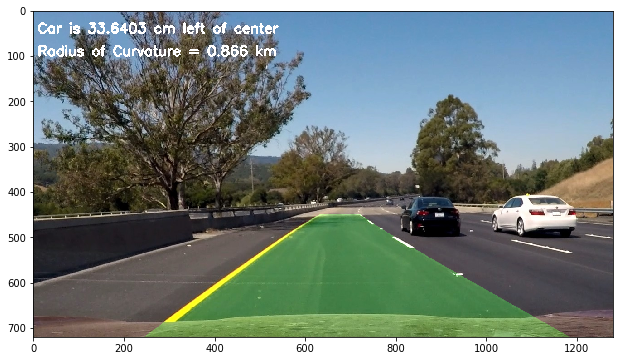

In [25]:
warp_img = warp_pipe(test_img, mtx, dist)
warp_bin_img = warp_img[:, :, 0]

l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window(warp_bin_img)

img_out, ploty = draw_lane(test_img, warp_bin_img, l_fit, r_fit)
rad, dev = radius_of_curvature(ploty, l_lane_inds, r_lane_inds, test_img.shape)
print(rad)
print(dev)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img_out, dev, (10,50), font, 1, (255,255,255), 3)
cv2.putText(img_out, rad, (10,100), font, 1, (255,255,255), 3)

plt.figure(figsize=(12,6))
plt.imshow(img_out)
plt.savefig("output_images/lane_radius_deviation_image.png")
plt.show()

In [26]:
def processing_pipeline(img):
    new_img = np.copy(img)
    warp_img = warp_pipe(new_img, mtx, dist)
    warp_bin_img = warp_img[:, :, 0]
    
    l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window(warp_bin_img)
    
    img_out, ploty = draw_lane(new_img, warp_bin_img, l_fit, r_fit)
    rad, dev = radius_of_curvature(ploty, l_lane_inds, r_lane_inds, new_img.shape)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_out, dev, (10,50), font, 1, (255,255,255), 2)
    cv2.putText(img_out, rad, (10,100), font, 1, (255,255,255), 2)
    
    return img_out

In [27]:
from moviepy.editor import VideoFileClip
"""
left_line = Line()
right_line = Line()
"""
input_video = VideoFileClip('project_video.mp4')
processed_video = input_video.fl_image(processing_pipeline)

output_video = 'project_video_output.mp4'
%time processed_video.write_videofile(output_video, audio=False)

459.941514465 576.289001645
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 2/1261 [00:00<01:23, 15.06it/s]

459.941514465 576.289001645
456.260031523 520.883471331
434.608628922 703.462144713


  0%|          | 4/1261 [00:00<01:20, 15.67it/s]

416.467746112 612.910105967


  0%|          | 6/1261 [00:00<01:18, 16.07it/s]

436.656059874 584.569677545
442.358862971 384.019672272
468.585126107 374.690875114


  1%|          | 8/1261 [00:00<01:16, 16.45it/s]

468.971061276 437.333137924


  1%|          | 10/1261 [00:00<01:14, 16.77it/s]

505.49923483 469.75647568
531.634604319 605.378337895
554.00195425 556.78503746


  1%|          | 12/1261 [00:00<01:13, 16.99it/s]

627.648282206 579.240773428


  1%|          | 14/1261 [00:00<01:12, 17.20it/s]

613.077802369 932.680634673
639.195461088 683.79203704
608.749960303 599.345827879


  1%|▏         | 16/1261 [00:00<01:11, 17.34it/s]

569.426040335 712.417151985


  1%|▏         | 18/1261 [00:01<01:11, 17.45it/s]

572.901145517 632.077369326
618.318636928 294.634317575
639.720440042 298.05528272


  2%|▏         | 20/1261 [00:01<01:10, 17.57it/s]

685.990285058 336.387386509


  2%|▏         | 22/1261 [00:01<01:10, 17.58it/s]

777.86918943 367.568658875
833.164261152 404.869669863
858.768329462 410.816435724


  2%|▏         | 24/1261 [00:01<01:10, 17.60it/s]

754.932076667 435.796314126


  2%|▏         | 26/1261 [00:01<01:10, 17.59it/s]

667.261125401 830.102440298
714.83672144 688.947579495
669.528022435 519.538301297


  2%|▏         | 28/1261 [00:01<01:09, 17.64it/s]

610.438490682 532.441154601


  2%|▏         | 30/1261 [00:01<01:10, 17.57it/s]

564.560272546 703.834096928
517.312168225 594.326733108
488.992773123 482.338543679


  3%|▎         | 32/1261 [00:01<01:09, 17.59it/s]

431.517040623 281.978050715


  3%|▎         | 34/1261 [00:01<01:09, 17.64it/s]

443.334899743 311.92520795
413.406153549 389.493528148
403.183972298 401.908410487


  3%|▎         | 36/1261 [00:02<01:09, 17.73it/s]

394.854839428 369.064426582


  3%|▎         | 38/1261 [00:02<01:08, 17.78it/s]

382.847195329 597.581510938
364.967121584 418.595318111
352.746572262 406.756101753


  3%|▎         | 40/1261 [00:02<01:08, 17.78it/s]

349.346014162 418.323121991


  3%|▎         | 42/1261 [00:02<01:08, 17.83it/s]

343.565692603 605.281744826
352.299552526 439.646486687
373.982953629 469.248542492


  3%|▎         | 44/1261 [00:02<01:09, 17.59it/s]

385.10689211 363.471803493


  4%|▎         | 46/1261 [00:02<01:08, 17.64it/s]

404.786774767 262.433021045
418.227514523 715.613780455
439.732865025 432.392225617


  4%|▍         | 48/1261 [00:02<01:09, 17.56it/s]

445.307056783 417.83646912


  4%|▍         | 50/1261 [00:02<01:09, 17.43it/s]

476.519835689 371.244998629
503.123853884 476.804376028
538.961374606 523.889159574


  4%|▍         | 52/1261 [00:02<01:09, 17.38it/s]

560.939975551 448.214416373


  4%|▍         | 54/1261 [00:03<01:09, 17.38it/s]

547.053875691 449.967297089
557.854589624 615.249302621
618.238475742 470.388257785


  4%|▍         | 56/1261 [00:03<01:09, 17.35it/s]

677.931777397 492.19556698


  5%|▍         | 58/1261 [00:03<01:09, 17.31it/s]

729.486172204 489.127864687
723.036142663 682.618182351
663.069334178 579.030697644


  5%|▍         | 60/1261 [00:03<01:09, 17.31it/s]

646.107313099 568.709193308


  5%|▍         | 62/1261 [00:03<01:09, 17.27it/s]

606.609841771 510.070982885
595.002282324 519.908337832
598.876642451 516.0752421


  5%|▌         | 64/1261 [00:03<01:09, 17.15it/s]

581.539171599 416.467967239


  5%|▌         | 66/1261 [00:03<01:10, 17.03it/s]

598.612722874 472.264596004
545.079543025 656.747262619
524.078789362 571.735282474


  5%|▌         | 68/1261 [00:03<01:10, 17.02it/s]

606.986368558 548.150520637


  6%|▌         | 70/1261 [00:04<01:09, 17.02it/s]

603.534966455 290.509695146
610.275655157 381.014467426
609.075707944 414.076919118


  6%|▌         | 72/1261 [00:04<01:09, 17.09it/s]

640.351661342 425.688913877


  6%|▌         | 74/1261 [00:04<01:09, 17.11it/s]

684.162616067 449.469850826
724.792467848 481.248615083
780.896083841 493.380633829


  6%|▌         | 76/1261 [00:04<01:08, 17.18it/s]

789.388840057 439.728966861


  6%|▌         | 78/1261 [00:04<01:09, 17.14it/s]

991.695319736 459.263015945
1055.0314736 466.816811254
1121.98089601 471.014865261


  6%|▋         | 80/1261 [00:04<01:08, 17.15it/s]

974.21533097 511.531490931


  7%|▋         | 82/1261 [00:04<01:08, 17.11it/s]

1164.91085267 518.298323167
1175.07273035 300.934549184
1043.76956605 398.963464375


  7%|▋         | 84/1261 [00:04<01:08, 17.20it/s]

1178.54867654 626.964514754


  7%|▋         | 86/1261 [00:04<01:08, 17.14it/s]

1069.67434455 539.940255749
908.400853654 504.967182826
672.262063167 511.300291674


  7%|▋         | 88/1261 [00:05<01:08, 17.09it/s]

592.322014654 560.204721525


  7%|▋         | 90/1261 [00:05<01:08, 17.12it/s]

510.028739563 485.105598962
486.59954721 447.821406615
467.726164299 591.203306277


  7%|▋         | 92/1261 [00:05<01:08, 17.03it/s]

470.099990916 541.093024765


  7%|▋         | 94/1261 [00:05<01:08, 17.05it/s]

467.349432101 558.128316905
456.241448248 386.617830438
465.421819051 316.256789651


  8%|▊         | 96/1261 [00:05<01:08, 16.98it/s]

472.552559948 463.146529846


  8%|▊         | 98/1261 [00:05<01:08, 16.95it/s]

492.857904902 478.789215028
494.98533496 471.905241504
497.512716112 498.546296751


  8%|▊         | 100/1261 [00:05<01:07, 17.09it/s]

494.728702855 526.172223302


  8%|▊         | 102/1261 [00:05<01:08, 17.02it/s]

493.277019928 443.247248673
489.858048392 423.561390832
485.324193446 452.222710132


  8%|▊         | 104/1261 [00:06<01:07, 17.05it/s]

474.669616624 519.941144131


  8%|▊         | 106/1261 [00:06<01:07, 17.05it/s]

490.344360039 480.557385653
507.842492818 491.476192472
524.791365222 382.357034271


  9%|▊         | 108/1261 [00:06<01:09, 16.65it/s]

493.3642434 446.882454226


  9%|▊         | 110/1261 [00:06<01:08, 16.78it/s]

489.933338139 418.413993122
489.531211332 373.439095807
477.992330144 397.783993131


  9%|▉         | 112/1261 [00:06<01:08, 16.85it/s]

503.750581888 396.576889168


  9%|▉         | 114/1261 [00:06<01:07, 16.91it/s]

463.876029444 523.757317414
468.903972369 417.969062191
428.79795531 369.933439685


  9%|▉         | 116/1261 [00:06<01:07, 17.01it/s]

412.57398881 380.319190363


  9%|▉         | 118/1261 [00:06<01:07, 17.02it/s]

406.044432911 419.23276697
418.761196772 431.00781171
419.228155158 428.287483289


 10%|▉         | 120/1261 [00:06<01:06, 17.13it/s]

399.856475293 289.841804572


 10%|▉         | 122/1261 [00:07<01:06, 17.23it/s]

400.916659462 368.045001763
398.069840515 418.575802972
389.294912759 399.235128382


 10%|▉         | 124/1261 [00:07<01:05, 17.25it/s]

398.61355365 490.416948712


 10%|▉         | 126/1261 [00:07<01:05, 17.31it/s]

401.190498722 374.910203337
431.763776194 413.850589727
420.647274743 406.255901536


 10%|█         | 128/1261 [00:07<01:05, 17.20it/s]

428.360155573 423.064502287


 10%|█         | 130/1261 [00:07<01:05, 17.22it/s]

413.741869448 452.344272065
437.87750905 444.733759146
455.050670176 459.267070838


 10%|█         | 132/1261 [00:07<01:05, 17.32it/s]

452.964653263 296.805854671


 11%|█         | 134/1261 [00:07<01:04, 17.39it/s]

466.666709933 391.381695847
482.351681454 540.808705692
491.411454109 525.161032694


 11%|█         | 136/1261 [00:07<01:04, 17.41it/s]

522.30559154 472.717012841


 11%|█         | 138/1261 [00:08<01:04, 17.37it/s]

535.604971636 580.974835769
573.319141931 625.961666532
586.91655134 577.698003974


 11%|█         | 140/1261 [00:08<01:04, 17.31it/s]

625.19635505 575.933416735


 11%|█▏        | 142/1261 [00:08<01:04, 17.28it/s]

582.023481783 545.703789137
599.294287167 774.685518211
605.601751178 592.794068225


 11%|█▏        | 144/1261 [00:08<01:05, 17.17it/s]

605.537131038 557.54945366


 12%|█▏        | 146/1261 [00:08<01:04, 17.17it/s]

603.131236783 418.665172609
562.713208829 445.733623744
585.600581393 517.557260337


 12%|█▏        | 148/1261 [00:08<01:04, 17.14it/s]

514.122969275 492.751716854


 12%|█▏        | 150/1261 [00:08<01:06, 16.78it/s]

510.420195685 473.967118136
542.672998657 540.900536022
556.947633911 451.724204822


 12%|█▏        | 152/1261 [00:08<01:05, 16.85it/s]

602.144820732 457.404280233


 12%|█▏        | 154/1261 [00:08<01:05, 17.00it/s]

526.840748036 426.733648828
559.682067314 649.18233332
603.415446305 543.071987262


 12%|█▏        | 156/1261 [00:09<01:04, 17.12it/s]

613.720177446 564.228898485


 13%|█▎        | 158/1261 [00:09<01:04, 17.22it/s]

582.58087177 484.149038895
544.551803674 492.374506575
547.44046219 549.779072364


 13%|█▎        | 160/1261 [00:09<01:03, 17.26it/s]

507.468637661 546.029012026


 13%|█▎        | 162/1261 [00:09<01:03, 17.20it/s]

532.507522659 554.243912503
536.362986062 668.318285913
537.570216882 609.529082306


 13%|█▎        | 164/1261 [00:09<01:03, 17.16it/s]

510.184414779 505.202440275


 13%|█▎        | 166/1261 [00:09<01:03, 17.19it/s]

494.357726917 412.377250998
477.17662285 715.713352885
463.674663046 556.48588697


 13%|█▎        | 168/1261 [00:09<01:03, 17.23it/s]

552.196994028 517.20896213


 13%|█▎        | 170/1261 [00:09<01:04, 16.86it/s]

566.021759173 542.203570814
591.972132593 344.161771225
611.292372821 328.435946049


 14%|█▎        | 172/1261 [00:09<01:03, 17.04it/s]

608.842479847 269.469920649


 14%|█▍        | 174/1261 [00:10<01:03, 17.10it/s]

605.281901213 269.830187058
562.863199153 316.096228102
539.327377831 272.332624881


 14%|█▍        | 176/1261 [00:10<01:03, 17.16it/s]

552.482998057 267.404158456


 14%|█▍        | 178/1261 [00:10<01:03, 17.00it/s]

605.019965621 272.968377701
562.972722405 292.167224867
551.137233959 383.953869628


 14%|█▍        | 180/1261 [00:10<01:05, 16.57it/s]

599.817568887 323.818637876


 14%|█▍        | 182/1261 [00:10<01:04, 16.82it/s]

529.380283241 338.893804191
513.536827966 353.344556926
458.763691251 365.89439304


 15%|█▍        | 184/1261 [00:10<01:03, 17.05it/s]

418.532135525 376.965781697


 15%|█▍        | 186/1261 [00:10<01:02, 17.15it/s]

383.790030318 377.06938262
335.865314845 326.386359215
330.52073199 336.234880018


 15%|█▍        | 188/1261 [00:10<01:02, 17.22it/s]

321.835057755 389.099491196


 15%|█▌        | 190/1261 [00:11<01:02, 17.24it/s]

330.363997204 342.836198294
322.329915142 426.787434095
320.023639636 386.611159036


 15%|█▌        | 192/1261 [00:11<01:02, 17.18it/s]

361.805430776 371.919011962


 15%|█▌        | 194/1261 [00:11<01:02, 17.02it/s]

361.896498527 233.368180706
380.436714178 253.115751824
387.501896728 315.003531417


 16%|█▌        | 196/1261 [00:11<01:03, 16.78it/s]

442.519018119 388.462619947


 16%|█▌        | 198/1261 [00:11<01:02, 16.92it/s]

497.023040449 417.155683087
564.01573357 380.246700894
619.451576586 376.891646999


 16%|█▌        | 200/1261 [00:11<01:02, 17.06it/s]

626.442812106 431.827955146


 16%|█▌        | 202/1261 [00:11<01:01, 17.09it/s]

667.7847601 677.058701668
610.622192591 450.796103318
506.273786645 450.594920416


 16%|█▌        | 204/1261 [00:11<01:01, 17.15it/s]

525.322550736 653.146951867


 16%|█▋        | 206/1261 [00:11<01:01, 17.13it/s]

532.283542531 423.028704397
519.759988695 451.044381588
477.017558945 318.660316162


 16%|█▋        | 208/1261 [00:12<01:02, 16.94it/s]

452.679821657 468.862512523


 17%|█▋        | 210/1261 [00:12<01:01, 17.05it/s]

450.90671566 408.347076447
485.618596543 440.999461255
504.895037616 380.738831136


 17%|█▋        | 212/1261 [00:12<01:01, 17.16it/s]

478.523710378 470.157084552


 17%|█▋        | 214/1261 [00:12<01:00, 17.21it/s]

461.23785269 530.421931068
427.465365225 494.958735876
403.313613761 524.264359319


 17%|█▋        | 216/1261 [00:12<01:00, 17.23it/s]

393.827552975 698.088388151


 17%|█▋        | 218/1261 [00:12<01:00, 17.26it/s]

420.157258528 554.371951578
438.430405028 561.277517916
429.396665371 405.066520801


 17%|█▋        | 220/1261 [00:12<01:02, 16.74it/s]

473.756458466 550.178258059


 18%|█▊        | 222/1261 [00:12<01:03, 16.40it/s]

513.693823125 467.277661154
538.646113727 458.078816284
572.42649682 422.675458926


 18%|█▊        | 224/1261 [00:13<01:04, 16.09it/s]

534.241365151 539.096815976


 18%|█▊        | 226/1261 [00:13<01:04, 15.97it/s]

569.314183512 540.754460943
559.830421105 474.062858261
548.55040618 472.759218161


 18%|█▊        | 228/1261 [00:13<01:03, 16.31it/s]

575.353094315 700.10616824


 18%|█▊        | 230/1261 [00:13<01:02, 16.56it/s]

618.505587994 539.190524623
679.867371745 559.303456308
684.514855742 419.69956888


 18%|█▊        | 232/1261 [00:13<01:01, 16.85it/s]

789.954645817 453.49155786


 19%|█▊        | 234/1261 [00:13<01:00, 16.98it/s]

810.388716775 362.888641665
836.613849404 418.038887956
850.569710322 384.432629019


 19%|█▊        | 236/1261 [00:13<01:00, 17.08it/s]

754.616720262 351.443562485


 19%|█▉        | 238/1261 [00:13<01:01, 16.54it/s]

757.584721978 362.530667947
699.639341708 317.360819151
630.096491548 

 19%|█▉        | 240/1261 [00:14<01:03, 16.20it/s]

342.111116238
642.099316995 400.127482349


 19%|█▉        | 242/1261 [00:14<01:01, 16.49it/s]

647.774819965 380.262461687
713.684133354 406.855579422
611.885350268 290.914932198


 19%|█▉        | 244/1261 [00:14<01:00, 16.73it/s]

627.970362568 266.813664959


 20%|█▉        | 246/1261 [00:14<01:01, 16.45it/s]

593.342317956 407.308895357
562.425107105 393.644081075
567.974518094 366.913959322


 20%|█▉        | 248/1261 [00:14<01:01, 16.52it/s]

521.080831907 344.410198773


 20%|█▉        | 250/1261 [00:14<01:00, 16.69it/s]

566.613857831 354.758179881
545.170324839 366.582156963
567.505955054 365.340235563


 20%|█▉        | 252/1261 [00:14<01:00, 16.80it/s]

606.065784538 444.884964898


 20%|██        | 254/1261 [00:14<00:59, 16.79it/s]

596.730483416 420.050276878
644.140713024 440.149489397
623.427498178 416.150123566


 20%|██        | 256/1261 [00:14<01:01, 16.40it/s]

641.891039214 297.224695759


 20%|██        | 258/1261 [00:15<01:00, 16.60it/s]

609.40665176 402.743831484
605.801642292 365.474792671
603.357647353 359.443391884


 21%|██        | 260/1261 [00:15<01:00, 16.68it/s]

584.321204532 321.151482888


 21%|██        | 262/1261 [00:15<00:59, 16.72it/s]

629.665477815 380.785020477
671.502893074 369.251296307
613.176283087 382.678893818


 21%|██        | 264/1261 [00:15<01:00, 16.59it/s]

611.50030089 469.111015527


 21%|██        | 266/1261 [00:15<00:59, 16.76it/s]

647.86766213 469.860410056
665.94672221 489.898069276
608.722496461 487.457323467


 21%|██▏       | 268/1261 [00:15<00:58, 16.87it/s]

616.723125082 409.238809907


 21%|██▏       | 270/1261 [00:15<00:58, 16.97it/s]

661.874424931 439.305758149
640.023887183 463.83647577
637.153239544 474.960590016


 22%|██▏       | 272/1261 [00:15<00:58, 16.90it/s]

574.60453716 484.230093212


 22%|██▏       | 274/1261 [00:16<00:58, 16.89it/s]

599.840769954 466.983852277
574.112714727 474.786386789
575.429860736 488.56389014


 22%|██▏       | 276/1261 [00:16<00:58, 16.76it/s]

605.858147615 634.124219682


 22%|██▏       | 278/1261 [00:16<00:58, 16.79it/s]

662.179644091 601.414184473
694.361545456 614.69068351
671.616280097 437.655979651


 22%|██▏       | 280/1261 [00:16<00:58, 16.81it/s]

665.603848926 522.432734305


 22%|██▏       | 282/1261 [00:16<00:57, 16.91it/s]

691.980239149 630.225049892
690.55262912 561.990197116
728.391255101 581.517622689


 23%|██▎       | 284/1261 [00:16<00:57, 16.93it/s]

745.434713895 556.754476857


 23%|██▎       | 286/1261 [00:16<00:57, 16.91it/s]

790.851945485 572.507723166
858.255999908 633.272221245
820.778214916 583.637214644


 23%|██▎       | 288/1261 [00:16<00:57, 16.87it/s]

871.424094628 636.639221921


 23%|██▎       | 290/1261 [00:17<00:57, 16.88it/s]

938.64017266 730.28951609
968.558651226 663.851710884
925.49288664 419.680006758


 23%|██▎       | 292/1261 [00:17<00:57, 16.91it/s]

933.076266374 544.918218841


 23%|██▎       | 294/1261 [00:17<00:57, 16.86it/s]

939.764618888 655.124855565
973.17423219 587.348683534
980.667392506 579.39543285


 23%|██▎       | 296/1261 [00:17<00:57, 16.91it/s]

1006.91441939 695.878215312


 24%|██▎       | 298/1261 [00:17<00:56, 16.97it/s]

1042.30837578 719.314499371
1174.97176672 711.021405941
1170.59484921 683.515173059


 24%|██▍       | 300/1261 [00:17<00:56, 17.04it/s]

1160.308253 671.876595612


 24%|██▍       | 302/1261 [00:17<00:56, 16.88it/s]

1295.41836172 991.226970678
1430.51339365 1006.53471447
1480.021881 985.83098498


 24%|██▍       | 304/1261 [00:17<00:56, 16.93it/s]

1514.89138433 979.333876025


 24%|██▍       | 306/1261 [00:17<00:56, 16.90it/s]

1591.72326339 1514.81340918
1885.21817417 18318.6763912
1944.25816342 3305.16509785


 24%|██▍       | 308/1261 [00:18<00:56, 16.85it/s]

2229.30739584 3479.60249933


 25%|██▍       | 310/1261 [00:18<00:56, 16.80it/s]

2698.74860313 1890.10915785
3460.27800229 1554.33722168
4960.39891517 1239.92145357


 25%|██▍       | 312/1261 [00:18<00:56, 16.86it/s]

5216.83681992 2096.99127768


 25%|██▍       | 314/1261 [00:18<00:56, 16.81it/s]

9837.69797828 1879.98985704
14625.9718267 1674.68309944
10558246.0696 720.974004257


 25%|██▌       | 316/1261 [00:18<00:56, 16.83it/s]

25284.28996 1053.33657014


 25%|██▌       | 318/1261 [00:18<00:55, 16.85it/s]

134914.247356 999.290555622
20739.8087949 696.312771135
13300.5197657 809.837279416


 25%|██▌       | 320/1261 [00:18<00:55, 16.85it/s]

24379.3322899 737.101224893


 26%|██▌       | 322/1261 [00:18<00:55, 16.91it/s]

9177.79028067 923.579418663
5035.72087831 880.730447007
6866.08594194 861.365640133


 26%|██▌       | 324/1261 [00:19<00:55, 16.92it/s]

7973.04302856 998.432667883


 26%|██▌       | 326/1261 [00:19<00:55, 16.92it/s]

3787.44973404 1251.84998264
3698.65821937 1654.44107887
4226.30398282 1513.84961145


 26%|██▌       | 328/1261 [00:19<00:54, 16.97it/s]

4743.76862097 1858.76782148


 26%|██▌       | 330/1261 [00:19<00:55, 16.91it/s]

6555.45750669 2021.75999032
6011.56461685 3370.9437873
5791.04931143 1624.36481765


 26%|██▋       | 332/1261 [00:19<00:55, 16.81it/s]

5416.58383781 1275.03869115


 26%|██▋       | 334/1261 [00:19<00:55, 16.82it/s]

9117.22756312 1336.33671302
10727.9882674 1292.62157209
21003.8882417 1807.95330871


 27%|██▋       | 336/1261 [00:19<00:54, 16.85it/s]

41770.3658827 1653.68205268


 27%|██▋       | 338/1261 [00:19<00:54, 16.83it/s]

38174.2900039 2570.23999213
5868.62588611 3029.66745563
7696.1159282 2766.56922142


 27%|██▋       | 340/1261 [00:19<00:54, 16.85it/s]

7615.18087991 2934.6794521


 27%|██▋       | 342/1261 [00:20<00:54, 16.81it/s]

16571.2999365 4434.86864659
23219.9238701 1376.34004344
6864859.57394 1277.70354767


 27%|██▋       | 344/1261 [00:20<00:54, 16.78it/s]

71539.8130577 1200.9828757


 27%|██▋       | 346/1261 [00:20<00:54, 16.88it/s]

14608.3269879 1688.8239721
19964.5922513 1600.2806827
13047.0680672 1554.6282112


 28%|██▊       | 348/1261 [00:20<00:54, 16.90it/s]

7950.28993397 2014.05783998


 28%|██▊       | 350/1261 [00:20<00:54, 16.81it/s]

9105.46528032 2657.85080685
65427.5748039 2319.95393839
98237.1181838 2202.74334754


 28%|██▊       | 352/1261 [00:20<00:54, 16.67it/s]

37231.4960552 1007.17862258


 28%|██▊       | 354/1261 [00:20<00:56, 16.13it/s]

7306.56812532 1029.0174715
10658.9563458 1400.80964059
11864.4847384 2477.46615258


 28%|██▊       | 356/1261 [00:20<00:55, 16.41it/s]

10831.5411661 1736.22130645


 28%|██▊       | 358/1261 [00:21<00:54, 16.48it/s]

9349.86063055 1369.74295186
10273.7773764 1302.59682175
3513.09626125 1623.41969143


 29%|██▊       | 360/1261 [00:21<00:55, 16.25it/s]

3265.46404169 1828.07680322


 29%|██▊       | 362/1261 [00:21<00:54, 16.39it/s]

2051.71143898 1860.94450105
1409.20233956 2618.28446094
1247.15595162 2569.57911712


 29%|██▉       | 364/1261 [00:21<00:54, 16.56it/s]

1248.46720719 1235.06680121


 29%|██▉       | 366/1261 [00:21<00:53, 16.63it/s]

1158.60865909 4301.44967361
1120.18049839 2883.70697588
1080.79219559 3403.00792845


 29%|██▉       | 368/1261 [00:21<00:55, 16.16it/s]

1034.85198605 4039.79131093


 29%|██▉       | 370/1261 [00:21<00:54, 16.29it/s]

1077.80238703 2072.75988374
1164.37516894 3319.07807124
1247.83942819 2673.61377038


 30%|██▉       | 372/1261 [00:21<00:53, 16.50it/s]

1420.24200334 4885.54889551


 30%|██▉       | 374/1261 [00:22<00:53, 16.62it/s]

1709.85732463 4536.20379608
1799.46120438 12636.4667531
2645.07983861 1400.27814743


 30%|██▉       | 376/1261 [00:22<00:53, 16.63it/s]

5687.75238419 2293.2773077


 30%|██▉       | 378/1261 [00:22<00:54, 16.33it/s]

14529.3476262 33862.3999526
10977.5775326 3587.75024913
6607.59232198 7605.87959111


 30%|███       | 380/1261 [00:22<00:53, 16.52it/s]

3993.1582378 10055.0179242


 30%|███       | 382/1261 [00:22<00:53, 16.56it/s]

3256.80292202 5514.30544765
2651.16681367 9608.9538955
2637.24585318 8543.20208851


 30%|███       | 384/1261 [00:22<00:53, 16.30it/s]

2326.3964158 6530.32529758


 31%|███       | 386/1261 [00:22<00:53, 16.38it/s]

2364.0803838 9872.39687611
3362.05268168 8187.69934929
3123.73191584 5303.6854578


 31%|███       | 388/1261 [00:22<00:52, 16.50it/s]

3225.67765643 1838.12909388


 31%|███       | 390/1261 [00:23<00:52, 16.54it/s]

3489.06316326 1227.87432973
3608.94999376 1363.53763288
3523.64935298 1674.91620384


 31%|███       | 392/1261 [00:23<00:52, 16.67it/s]

3135.44618945 7249.86948535


 31%|███       | 394/1261 [00:23<00:53, 16.20it/s]

3833.16445888 4735.57477257
3690.86942018 2305.9337675
4142.13576646 2748.63380609


 31%|███▏      | 396/1261 [00:23<00:52, 16.35it/s]

6407.80818437 9125.91692979


 32%|███▏      | 398/1261 [00:23<00:52, 16.50it/s]

5461.00497712 4247.40046661
14051.497967 3274.93644446
6477.74439108 3731.60891585


 32%|███▏      | 400/1261 [00:23<00:51, 16.62it/s]

6554.46990464 1336.38088059


 32%|███▏      | 402/1261 [00:23<00:51, 16.69it/s]

8179.32490149 850.444395286
11387.072928 1268.69398488
60161.1235548 2592.02264545


 32%|███▏      | 404/1261 [00:23<00:51, 16.75it/s]

33375.5836646 2129.04680006


 32%|███▏      | 406/1261 [00:23<00:50, 16.78it/s]

33586.2165171 13644.7330094
1468097.34837 9276.74242801
33739.30116 3587.58503456


 32%|███▏      | 408/1261 [00:24<00:51, 16.42it/s]

66362.457819 6074.20227167


 33%|███▎      | 410/1261 [00:24<00:51, 16.43it/s]

15365.6744187 8985.70130897
16773.6135828 3867.09664382
16041.1853308 18027.2605407


 33%|███▎      | 412/1261 [00:24<00:51, 16.49it/s]

156260.466886 1216.91293872


 33%|███▎      | 414/1261 [00:24<00:52, 16.29it/s]

15926.4171779 1566.82538681
8107.52627053 1640.43656741
5002.15891619 2759.46049893


 33%|███▎      | 416/1261 [00:24<00:51, 16.45it/s]

3330.00049172 2456.44373136


 33%|███▎      | 418/1261 [00:24<00:50, 16.56it/s]

3735.95105993 7011.20649174
2643.04708746 3182.72970322
2586.71619681 7508.57483103


 33%|███▎      | 420/1261 [00:24<00:50, 16.65it/s]

2267.75216101 19859.0044136


 33%|███▎      | 422/1261 [00:24<00:50, 16.63it/s]

2598.52813158 4262.58892081
3714.77595492 644743.383401
3305.43651043 6576.90349034


 34%|███▎      | 424/1261 [00:25<00:49, 16.76it/s]

3829.05922352 1108.73153526


 34%|███▍      | 426/1261 [00:25<00:49, 16.73it/s]

3872.50992075 1402.15072283
4795.47595068 970.218567331
5264.65868385 2024.47303199


 34%|███▍      | 428/1261 [00:25<00:49, 16.81it/s]

7144.03114953 3377.02352614


 34%|███▍      | 430/1261 [00:25<00:49, 16.83it/s]

140187.031091 13012.2433746
230979.22124 6298.80469444
67741.2911149 16477.574275


 34%|███▍      | 432/1261 [00:25<00:49, 16.91it/s]

11789.61174 4852.92092013


 34%|███▍      | 434/1261 [00:25<00:49, 16.81it/s]

14968.7788654 6866.56703354
3518.14633889 5358.70849149
2559.01583583 4091.31398645


 35%|███▍      | 436/1261 [00:25<00:48, 16.86it/s]

2573.6569977 627.020088047


 35%|███▍      | 438/1261 [00:25<00:48, 16.82it/s]

2116.1104986 873.433984178
2108.68889931 1148.19397881
1876.83759324 1439.64042447


 35%|███▍      | 440/1261 [00:26<00:48, 16.81it/s]

1911.97915933 1194.86397772


 35%|███▌      | 442/1261 [00:26<00:48, 16.83it/s]

1964.4858684 2061.76319606
2126.50555592 1966.5809257
1868.30989144 2375.41906557


 35%|███▌      | 444/1261 [00:26<00:48, 16.83it/s]

2189.74405349 2163.69384078


 35%|███▌      | 446/1261 [00:26<00:48, 16.80it/s]

1897.63560249 3631.54132192
1758.3315042 2184.45890676
1839.550537 2041.85634222


 36%|███▌      | 448/1261 [00:26<00:49, 16.43it/s]

2101.71020464 823.54936912


 36%|███▌      | 450/1261 [00:26<00:49, 16.50it/s]

2415.24555687 1450.61648138
3010.42317214 1408.0041033
3847.51335341 1478.03051824


 36%|███▌      | 452/1261 [00:26<00:48, 16.65it/s]

6643.83621026 1961.69377174


 36%|███▌      | 454/1261 [00:26<00:49, 16.33it/s]

11109.0687077 3305.42409285
18108.1702152 7107.07924232
6676.21485881 28818.6211551


 36%|███▌      | 456/1261 [00:26<00:48, 16.43it/s]

4760.36611253 8112.63502059


 36%|███▋      | 458/1261 [00:27<00:48, 16.45it/s]

8076.9952052 6261.13713077
7636.01141704 8651.32036042
5200.50889199 1426.02710355


 36%|███▋      | 460/1261 [00:27<00:49, 16.20it/s]

4228.05100791 3897.22110021


 37%|███▋      | 462/1261 [00:27<00:48, 16.34it/s]

4608.01282178 5613.31424012
3997.55290112 6049.09766175
2957.28891991 5769.06140076


 37%|███▋      | 464/1261 [00:27<00:49, 16.23it/s]

2860.26538465 2396.45329937


 37%|███▋      | 466/1261 [00:27<00:48, 16.25it/s]

2653.27058571 2060.08829383
2350.71125313 1702.81361524
2533.09243283 2380.40814836


 37%|███▋      | 468/1261 [00:27<00:48, 16.38it/s]

4020.33515917 2318.29214549


 37%|███▋      | 470/1261 [00:27<00:48, 16.45it/s]

4948.97025284 4477.36171959
3890.67746178 2502.24802056
5522.67527325 1078.82730886


 37%|███▋      | 472/1261 [00:27<00:47, 16.61it/s]

7495.17974473 1410.28573534


 38%|███▊      | 474/1261 [00:28<00:47, 16.62it/s]

13356.1832788 1875.48136533
38223.0181108 4141.35233627
24444.5550346 2396.63985275


 38%|███▊      | 476/1261 [00:28<00:47, 16.65it/s]

68802.1710652 35610.1127829


 38%|███▊      | 478/1261 [00:28<00:46, 16.69it/s]

13488.2931335 45485.9677315
11257.7689855 7885.74281644
4777.67251162 4946.81048111


 38%|███▊      | 480/1261 [00:28<00:46, 16.76it/s]

4980.46039841 63170.415528


 38%|███▊      | 482/1261 [00:28<00:46, 16.78it/s]

5712.45448884 27400.5667913
3033.45413374 21239.6980458
3578.73684892 24691.6980097


 38%|███▊      | 484/1261 [00:28<00:47, 16.24it/s]

4979.41077334 869.461997049


 39%|███▊      | 486/1261 [00:28<00:48, 15.85it/s]

5444.07088249 988.648761266
4652.21311104 1149.23685475
6760.51759433 1666.25305653


 39%|███▊      | 488/1261 [00:28<00:48, 16.05it/s]

11615.7148106 2810.37385447


 39%|███▉      | 490/1261 [00:29<00:47, 16.27it/s]

49357.2788039 4860.23603915
69151.5778049 3485.93742235
19494.2412598 5841.76817575


 39%|███▉      | 492/1261 [00:29<00:47, 16.24it/s]

86728.4782351 9873.86306421


 39%|███▉      | 494/1261 [00:29<00:46, 16.42it/s]

395380.959014 5826.7911995
11353.1241904 10518.1637896
17338.7548874 1067.68463208


 39%|███▉      | 496/1261 [00:29<00:46, 16.50it/s]

19891.2403784 757.229840136


 39%|███▉      | 498/1261 [00:29<00:46, 16.49it/s]

61769.5141989 1109.32092948
43157.1092303 1907.06115415
102623.569584 2750.08293837


 40%|███▉      | 500/1261 [00:29<00:46, 16.31it/s]

7322.33038717 2417.54947316


 40%|███▉      | 502/1261 [00:29<00:46, 16.39it/s]

8287.51940651 3437.48914538
11396.670374 8818.07214927
6655.6833263 6711.20767307


 40%|███▉      | 504/1261 [00:29<00:46, 16.21it/s]

5564.79678174 18804.7726331


 40%|████      | 506/1261 [00:30<00:46, 16.25it/s]

12390.5059734 37500.3846585
88742.7484715 8625.82110828
28527.8014471 535433.343548


 40%|████      | 508/1261 [00:30<00:46, 16.35it/s]

12123.0124575 481.367866238


 40%|████      | 510/1261 [00:30<00:45, 16.48it/s]

12054.2584012 1291.40635126
88343.3762856 989.562305392
25448.9063615 1072.19629737


 41%|████      | 512/1261 [00:30<00:45, 16.46it/s]

38097.0083824 1330.13385129


 41%|████      | 514/1261 [00:30<00:45, 16.49it/s]

36302.1426501 2548.89769736
8777.16602028 4678.94311041
19533.88852 4513.23010884


 41%|████      | 516/1261 [00:30<00:45, 16.52it/s]

13963.2557752 6742.72618979


 41%|████      | 518/1261 [00:30<00:44, 16.51it/s]

8911.61229691 5777.77661023
6316.20074533 3359.44517626
5512.49075374 3133.45502494


 41%|████      | 520/1261 [00:30<00:44, 16.58it/s]

4923.63572515 534.622092515


 41%|████▏     | 522/1261 [00:30<00:44, 16.62it/s]

6801.19324597 1144.77849711
62956.9850926 2796.86293102
17208.5654381 2688.51371866


 42%|████▏     | 524/1261 [00:31<00:44, 16.67it/s]

6195.53521216 3947.08644346


 42%|████▏     | 526/1261 [00:31<00:44, 16.67it/s]

2188.08967794 3878.1888243
3316.51939837 68524.27291
1708.1845718 7883.98377484


 42%|████▏     | 528/1261 [00:31<00:43, 16.74it/s]

6850.48099233 55940.415286


 42%|████▏     | 530/1261 [00:31<00:43, 16.83it/s]

4209.98839936 3666.11375104
5956.91367898 6920.42965723
4744.98348087 9514.34184076


 42%|████▏     | 532/1261 [00:31<00:42, 17.00it/s]

7726.30707383 1095.35077775


 42%|████▏     | 534/1261 [00:31<00:43, 16.67it/s]

2689.10626267 917.852112168
1423.59201066 2531.43825829
10757.3640043 2871.41523004


 43%|████▎     | 536/1261 [00:31<00:43, 16.64it/s]

8076.0469461 4342.10685231


 43%|████▎     | 538/1261 [00:31<00:42, 16.86it/s]

3198.30347281 3744.17237657
6923.10424621 25812.2795567
3638.81531442 69416.4567716


 43%|████▎     | 540/1261 [00:32<00:42, 16.93it/s]

2723.88831299 2419.84193714


 43%|████▎     | 542/1261 [00:32<00:42, 16.98it/s]

1974.19134652 3311.39417407
3218.75980022 29536.5800457
2901.81066156 2122.4796254


 43%|████▎     | 544/1261 [00:32<00:42, 17.03it/s]

3106.04882367 2517.21948339


 43%|████▎     | 546/1261 [00:32<00:43, 16.58it/s]

2251.14963306 9862.75603984
1698.32717296 1884.89550826
1885.27194748 1252.65759574


 43%|████▎     | 548/1261 [00:32<00:42, 16.92it/s]

2250.57392193 1306.95240215


 44%|████▎     | 550/1261 [00:32<00:41, 17.08it/s]

1624.47130422 1195.68187793
1566.42914422 1330.95882642
1600.89021346 1281.30412067


 44%|████▍     | 552/1261 [00:32<00:41, 17.03it/s]

1895.34597212 9149.86597919


 44%|████▍     | 554/1261 [00:32<00:41, 17.04it/s]

1711.15659976 1698.19327219
1761.53370405 3912.01624213
2187.56115155 531.871309371


 44%|████▍     | 556/1261 [00:33<00:41, 17.02it/s]

2156.611714 434.330311051


 44%|████▍     | 558/1261 [00:33<00:41, 17.07it/s]

2147.25741133 588.475678948
2017.08323364 628.693818141
3347.12159341 732.618223047


 44%|████▍     | 560/1261 [00:33<00:41, 17.09it/s]

3349.85924362 156.879733335


 45%|████▍     | 562/1261 [00:33<00:41, 16.92it/s]

3039.17380484 1225.72028289
2062.34603697 1420.72684172
2333.34280052 82908.1721247


 45%|████▍     | 564/1261 [00:33<00:42, 16.50it/s]

1855.50995924 308.217146166


 45%|████▍     | 566/1261 [00:33<00:41, 16.83it/s]

1488.75817963 317.796143742
2312.52177357 401.538672671
3980.75422974 971.479321337


 45%|████▌     | 568/1261 [00:33<00:41, 16.64it/s]

6896.68666975 916.379481914


 45%|████▌     | 570/1261 [00:33<00:40, 16.88it/s]

1936114.16643 998.673377604
7955.96778339 1198.92756441
9554.1858368 1477.80709683


 45%|████▌     | 572/1261 [00:33<00:40, 17.10it/s]

10610.9241029 1544.41024633


 46%|████▌     | 574/1261 [00:34<00:39, 17.36it/s]

4969.48934817 1953.5890272
3291.51738807 1359.51973409
14106.3730206 1493.21993459


 46%|████▌     | 576/1261 [00:34<00:39, 17.36it/s]

16292.9435542 387.243128053


 46%|████▌     | 578/1261 [00:34<00:39, 17.13it/s]

2089.4480868 909.343125284
1080.34322955 2245.52223833
4686.44907986 171.677335651


 46%|████▌     | 580/1261 [00:34<00:39, 17.20it/s]

2796.98982162 6888.67282433


 46%|████▌     | 582/1261 [00:34<00:38, 17.48it/s]

2972.00024054 3003.36380562
4816.69198027 1881.44296471
70622.3387592 1714.24724279


 46%|████▋     | 584/1261 [00:34<00:38, 17.71it/s]

764.389361706 1235.77199402


 46%|████▋     | 586/1261 [00:34<00:37, 17.88it/s]

778.003366652 1328.15578548
2350.40694703 1020.39719852
2001.9372883 1379.22608471


 47%|████▋     | 588/1261 [00:34<00:37, 18.03it/s]

8522.01659398 812.633431565


 47%|████▋     | 590/1261 [00:34<00:38, 17.53it/s]

20557.6427926 85960.4831797
2336.99382129 6958.26932493
2148.66963414 1452.99584532


 47%|████▋     | 592/1261 [00:35<00:38, 17.39it/s]

2816.87125277 1420.5610877


 47%|████▋     | 594/1261 [00:35<00:38, 17.54it/s]

3293.27353833 1954.30058505
4757.3596475 2327.71766809
5588.30646951 16157.1707618


 47%|████▋     | 596/1261 [00:35<00:37, 17.67it/s]

4301.22784302 2313.94726462


 47%|████▋     | 598/1261 [00:35<00:37, 17.68it/s]

3892.05363419 1970.55195556
3326.19257935 1456.9283648
2771.91123616 1936.52748303


 48%|████▊     | 600/1261 [00:35<00:37, 17.61it/s]

1070.54627449 3888.45379235


 48%|████▊     | 602/1261 [00:35<00:37, 17.62it/s]

1047.98602863 1588.62866376
929.508723399 1170.67106476
784.071108077 937.80300183


 48%|████▊     | 604/1261 [00:35<00:37, 17.56it/s]

732.460594208 716.716841904


 48%|████▊     | 606/1261 [00:35<00:37, 17.46it/s]

564.460242822 447.980098801
452.963876785 429.689229446
410.812843949 383.617870668


 48%|████▊     | 608/1261 [00:35<00:37, 17.38it/s]

359.01319503 429.003775327


 48%|████▊     | 610/1261 [00:36<00:37, 17.25it/s]

415.700547017 430.652750233
399.328191884 435.601815114
403.632876556 451.410825617


 49%|████▊     | 612/1261 [00:36<00:37, 17.33it/s]

383.929491535 33.3355366937


 49%|████▊     | 614/1261 [00:36<00:37, 17.30it/s]

353.39036822 83.5207501558
333.160822616 1112.93170966
332.10431994 616.782972539


 49%|████▉     | 616/1261 [00:36<00:37, 17.14it/s]

353.168901295 1737.69692929


 49%|████▉     | 618/1261 [00:36<00:37, 17.01it/s]

359.862489782 1600.26916271
363.8312726 845.392913376
309.780312313 585.227496921


 49%|████▉     | 620/1261 [00:36<00:37, 16.95it/s]

341.306390131 631.696961181


 49%|████▉     | 622/1261 [00:36<00:37, 16.88it/s]

382.406181393 612.533845053
389.396952093 713.342904275
385.30462893 642.350775723


 49%|████▉     | 624/1261 [00:36<00:37, 16.77it/s]

376.147248689 616.756562593


 50%|████▉     | 626/1261 [00:37<00:37, 16.80it/s]

368.864963962 469.103465151
368.368950071 526.082107744
362.570351288 567.436808706


 50%|████▉     | 628/1261 [00:37<00:37, 16.77it/s]

364.224382721 475.552090055


 50%|████▉     | 630/1261 [00:37<00:37, 16.78it/s]

391.122914984 433.580913251
477.112678733 463.156043126
534.477326173 568.986338363


 50%|█████     | 632/1261 [00:37<00:37, 16.76it/s]

592.987051488 640.781683481


 50%|█████     | 634/1261 [00:37<00:37, 16.77it/s]

627.094063485 604.453782873
645.608407655 479.234519637
606.123655799 425.525369944


 50%|█████     | 636/1261 [00:37<00:37, 16.83it/s]

591.30405065 381.094271574


 51%|█████     | 638/1261 [00:37<00:36, 16.86it/s]

494.857079734 326.148322227
568.373986729 388.902720093
563.402322071 416.353054501


 51%|█████     | 640/1261 [00:37<00:36, 16.86it/s]

662.745603076 562.779615849


 51%|█████     | 642/1261 [00:38<00:36, 16.83it/s]

736.160447556 622.778550236
777.433167557 563.206677549
760.888677008 475.018802783


 51%|█████     | 644/1261 [00:38<00:36, 16.81it/s]

726.788689132 443.400963109


 51%|█████     | 646/1261 [00:38<00:37, 16.21it/s]

667.87345736 446.694214532
609.489259016 439.8891235
564.044828241 444.295246963


 51%|█████▏    | 648/1261 [00:38<00:37, 16.30it/s]

547.245951721 465.910706951


 52%|█████▏    | 650/1261 [00:38<00:37, 16.44it/s]

561.922315483 505.354367006
587.349604258 537.373018829
544.299889999 538.482462154


 52%|█████▏    | 652/1261 [00:38<00:36, 16.52it/s]

541.697681647 588.439008042


 52%|█████▏    | 654/1261 [00:38<00:36, 16.63it/s]

517.776716599 517.394299661
500.490953057 468.678868049
456.076166773 472.260184131


 52%|█████▏    | 656/1261 [00:38<00:36, 16.64it/s]

452.558293251 539.578487807


 52%|█████▏    | 658/1261 [00:38<00:36, 16.64it/s]

436.347451158 534.134420313
419.33118223 542.347230777
422.17798549 550.476557098


 52%|█████▏    | 660/1261 [00:39<00:35, 16.71it/s]

429.03886514 576.383462191


 52%|█████▏    | 662/1261 [00:39<00:35, 16.70it/s]

453.960617415 579.156912797
470.673433519 670.087770301
482.477914937 679.482499911


 53%|█████▎    | 664/1261 [00:39<00:35, 16.64it/s]

483.593695335 690.443914625


 53%|█████▎    | 666/1261 [00:39<00:35, 16.63it/s]

484.975230854 682.142943708
501.89189627 507.736606826
504.286498151 496.169935228


 53%|█████▎    | 668/1261 [00:39<00:35, 16.63it/s]

546.631137739 509.119491029


 53%|█████▎    | 670/1261 [00:39<00:35, 16.61it/s]

585.613769596 518.25173782
581.12100992 552.437597647
625.701363066 546.366639902


 53%|█████▎    | 672/1261 [00:39<00:35, 16.65it/s]

589.649148075 506.995791816


 53%|█████▎    | 674/1261 [00:39<00:35, 16.68it/s]

656.640183838 553.565151123
678.664736952 563.628594346
704.262808019 585.588373156


 54%|█████▎    | 676/1261 [00:40<00:36, 16.07it/s]

668.598588355 570.17626639


 54%|█████▍    | 678/1261 [00:40<00:35, 16.21it/s]

652.631214421 521.621472161
705.468325894 503.180704565
654.634969363 460.881989925


 54%|█████▍    | 680/1261 [00:40<00:35, 16.43it/s]

651.807343972 487.094852253


 54%|█████▍    | 682/1261 [00:40<00:34, 16.59it/s]

616.465284225 511.725086279
624.957601984 509.310741708
579.416977285 524.652891618


 54%|█████▍    | 684/1261 [00:40<00:34, 16.52it/s]

576.220549097 519.517749961


 54%|█████▍    | 686/1261 [00:40<00:34, 16.55it/s]

565.647243852 529.832070994
525.953590315 529.48369237
527.056604796 536.465143188


 55%|█████▍    | 688/1261 [00:40<00:34, 16.57it/s]

515.910598659 580.557026784


 55%|█████▍    | 690/1261 [00:40<00:34, 16.59it/s]

514.801486274 604.760861063
497.491672308 628.748857343
467.451583053 539.344961723


 55%|█████▍    | 692/1261 [00:41<00:34, 16.61it/s]

435.166696218 473.527049609


 55%|█████▌    | 694/1261 [00:41<00:34, 16.63it/s]

419.660239369 486.264407096
429.624105986 516.05798052
430.718366117 502.479612903


 55%|█████▌    | 696/1261 [00:41<00:33, 16.69it/s]

433.994001751 463.274318504


 55%|█████▌    | 698/1261 [00:41<00:33, 16.65it/s]

434.21899812 511.926387258
411.717189305 495.584183499
427.986113014 524.386465736


 56%|█████▌    | 700/1261 [00:41<00:33, 16.67it/s]

396.664459409 483.642015023


 56%|█████▌    | 702/1261 [00:41<00:33, 16.70it/s]

405.361066432 479.324636566
416.947366929 408.208251579
427.032549062 431.564729726


 56%|█████▌    | 704/1261 [00:41<00:33, 16.73it/s]

459.545591199 388.660945874


 56%|█████▌    | 706/1261 [00:41<00:33, 16.80it/s]

437.882771224 398.451250024
467.348795414 395.500790353
481.347282903 399.381099417


 56%|█████▌    | 708/1261 [00:41<00:32, 16.82it/s]

506.066459682 396.224504711


 56%|█████▋    | 710/1261 [00:42<00:32, 16.75it/s]

482.772039045 393.232913506
495.597384323 419.331388418
494.201253018 434.519758904


 56%|█████▋    | 712/1261 [00:42<00:32, 16.73it/s]

525.695875454 462.036951479


 57%|█████▋    | 714/1261 [00:42<00:32, 16.76it/s]

512.699806596 477.030575297
500.765828382 422.78614431
460.029198103 413.42466615


 57%|█████▋    | 716/1261 [00:42<00:32, 16.83it/s]

457.462563544 388.530380583


 57%|█████▋    | 718/1261 [00:42<00:32, 16.79it/s]

486.29412982 414.171712126
481.550564116 440.762451866
513.569130279 478.302195408


 57%|█████▋    | 720/1261 [00:42<00:32, 16.79it/s]

513.441704401 465.993103478


 57%|█████▋    | 722/1261 [00:42<00:32, 16.78it/s]

503.417200322 467.480132639
509.87920139 503.144267115
494.505764588 510.923757618


 57%|█████▋    | 724/1261 [00:42<00:31, 16.83it/s]

500.994124919 540.474100151


 58%|█████▊    | 726/1261 [00:43<00:31, 16.86it/s]

510.065679447 581.164264993
482.449814421 660.258335782
467.835545152 634.23494555


 58%|█████▊    | 728/1261 [00:43<00:31, 16.76it/s]

458.817202926 488.582618833


 58%|█████▊    | 730/1261 [00:43<00:31, 16.80it/s]

464.301888517 487.52706343
454.518858546 494.274583818
460.395850721 461.172135414


 58%|█████▊    | 732/1261 [00:43<00:32, 16.37it/s]

471.485868252 440.105018635


 58%|█████▊    | 734/1261 [00:43<00:32, 16.45it/s]

438.499380054 414.105256778
454.374086555 431.293690883
452.057665923 444.127379422


 58%|█████▊    | 736/1261 [00:43<00:31, 16.51it/s]

446.303562608 450.97358161


 59%|█████▊    | 738/1261 [00:43<00:31, 16.56it/s]

454.050482885 489.337130039
436.410936257 462.022332588
463.274911994 456.8694453


 59%|█████▊    | 740/1261 [00:43<00:31, 16.63it/s]

481.577235401 357.956759311


 59%|█████▉    | 742/1261 [00:44<00:31, 16.69it/s]

484.61824992 393.815099009
508.668497782 377.276036646
486.841958802 392.325567243


 59%|█████▉    | 744/1261 [00:44<00:30, 16.75it/s]

516.350483426 386.59171223


 59%|█████▉    | 746/1261 [00:44<00:30, 16.79it/s]

514.657940893 394.453083813
531.394914611 417.068246685
530.850085779 436.256511409


 59%|█████▉    | 748/1261 [00:44<00:30, 16.83it/s]

549.357955942 449.862032522


 59%|█████▉    | 750/1261 [00:44<00:30, 16.84it/s]

556.185153374 470.309072319
577.232684168 509.08806895
544.032404559 533.34518117


 60%|█████▉    | 752/1261 [00:44<00:30, 16.79it/s]

593.611897229 536.479076691


 60%|█████▉    | 754/1261 [00:44<00:30, 16.74it/s]

538.59839532 506.928216733
491.141241956 465.627421369
488.292498216 470.601424375


 60%|█████▉    | 756/1261 [00:44<00:30, 16.71it/s]

534.863811039 511.434941614


 60%|██████    | 758/1261 [00:44<00:30, 16.65it/s]

514.695293456 499.625077012
507.140044543 538.251727834
506.532506304 557.230307846


 60%|██████    | 760/1261 [00:45<00:29, 16.74it/s]

493.089571165 586.646688471


 60%|██████    | 762/1261 [00:45<00:29, 16.79it/s]

457.38970042 621.724951113
461.911674784 791.544026856
460.449172513 768.899033732


 61%|██████    | 764/1261 [00:45<00:29, 16.85it/s]

457.709503459 721.981812741


 61%|██████    | 766/1261 [00:45<00:29, 16.87it/s]

449.941361202 646.911807956
447.696212176 576.684327968
425.555995958 590.089138026


 61%|██████    | 768/1261 [00:45<00:29, 16.83it/s]

423.847613598 584.554855378


 61%|██████    | 770/1261 [00:45<00:29, 16.84it/s]

417.920648547 565.913329349
410.592948315 599.994597032
433.861724701 609.81697382


 61%|██████    | 772/1261 [00:45<00:29, 16.83it/s]

450.670152583 659.838782765


 61%|██████▏   | 774/1261 [00:45<00:28, 16.88it/s]

471.777050654 694.137174078
452.568018405 656.241042587
460.822747283 534.986270281


 62%|██████▏   | 776/1261 [00:46<00:28, 16.92it/s]

473.205276813 458.804679618


 62%|██████▏   | 778/1261 [00:46<00:28, 16.96it/s]

454.809619925 482.810881069
458.375724501 447.530358279
479.176422349 455.125656174


 62%|██████▏   | 780/1261 [00:46<00:28, 16.95it/s]

508.723443997 475.560298302


 62%|██████▏   | 782/1261 [00:46<00:28, 16.95it/s]

554.696194944 465.113762381
616.367857052 507.79558588
629.530857937 529.570689295


 62%|██████▏   | 784/1261 [00:46<00:28, 16.95it/s]

647.362767885 594.196976182


 62%|██████▏   | 786/1261 [00:46<00:28, 16.88it/s]

638.261637428 609.182840358
686.392220671 726.227810325
710.85146722 697.668840513


 62%|██████▏   | 788/1261 [00:46<00:28, 16.89it/s]

710.316250532 605.171379327


 63%|██████▎   | 790/1261 [00:46<00:27, 16.88it/s]

674.428213624 553.291665033
674.671487137 630.330098946
699.364032171 663.514772502


 63%|██████▎   | 792/1261 [00:47<00:27, 16.88it/s]

783.019155496 677.311155675


 63%|██████▎   | 794/1261 [00:47<00:27, 16.92it/s]

798.748519867 769.497245111
815.440133457 809.32118367
780.215507599 885.273021445


 63%|██████▎   | 796/1261 [00:47<00:28, 16.47it/s]

832.500831066 817.320041315


 63%|██████▎   | 798/1261 [00:47<00:27, 16.56it/s]

816.116461251 886.456859199
773.991441241 2937.95473825
774.722862409 1638.84123924


 63%|██████▎   | 800/1261 [00:47<00:27, 16.66it/s]

804.207652848 1497.93439113


 64%|██████▎   | 802/1261 [00:47<00:27, 16.67it/s]

812.767733461 1015.86516118
818.200774498 1168.24365606
812.20712676 930.942785831


 64%|██████▍   | 804/1261 [00:47<00:27, 16.72it/s]

679.431583562 785.345278202


 64%|██████▍   | 806/1261 [00:47<00:27, 16.61it/s]

618.796509787 725.994942997
592.898049435 697.77934993
586.247457012 717.745607455


 64%|██████▍   | 808/1261 [00:47<00:27, 16.70it/s]

526.720377501 702.517556967


 64%|██████▍   | 810/1261 [00:48<00:26, 16.77it/s]

547.729390833 759.922137022
549.92616921 797.83217985
517.667834381 593.740094329


 64%|██████▍   | 812/1261 [00:48<00:26, 16.80it/s]

523.328933857 596.637070148


 65%|██████▍   | 814/1261 [00:48<00:26, 16.87it/s]

538.002341178 550.970240455
534.792389375 496.352369831
551.334552988 458.884062211


 65%|██████▍   | 816/1261 [00:48<00:26, 16.89it/s]

546.428300639 389.077496833


 65%|██████▍   | 818/1261 [00:48<00:26, 16.74it/s]

516.466736112 380.473668979
537.23151711 388.74395904
555.967236934 414.125133896


 65%|██████▌   | 820/1261 [00:48<00:26, 16.34it/s]

565.320684586 445.41696242


 65%|██████▌   | 822/1261 [00:48<00:27, 16.12it/s]

583.871193806 463.414744775
642.08605888 612.416578014
647.270925981 610.279035094


 65%|██████▌   | 824/1261 [00:48<00:26, 16.30it/s]

717.423052938 519.24612742


 66%|██████▌   | 826/1261 [00:49<00:27, 16.00it/s]

648.230264468 453.966297001
619.066888185 442.904044982
573.381883204 422.78587456


 66%|██████▌   | 828/1261 [00:49<00:26, 16.17it/s]

599.906436982 401.114304696


 66%|██████▌   | 830/1261 [00:49<00:26, 16.40it/s]

576.861495228 420.534409287
553.393274649 412.043125579
538.195759906 438.399363316


 66%|██████▌   | 832/1261 [00:49<00:26, 16.45it/s]

515.939462429 462.272464369


 66%|██████▌   | 834/1261 [00:49<00:25, 16.60it/s]

494.172254507 491.942705839
492.832798407 540.988677276
487.909748168 479.676890613


 66%|██████▋   | 836/1261 [00:49<00:25, 16.70it/s]

499.92375536 568.01195704


 66%|██████▋   | 838/1261 [00:49<00:25, 16.77it/s]

498.885301205 558.179290061
500.887992339 541.502678584
459.323545737 517.353441617


 67%|██████▋   | 840/1261 [00:49<00:25, 16.82it/s]

450.661289051 460.541565477


 67%|██████▋   | 842/1261 [00:50<00:24, 16.81it/s]

453.846519903 516.090016672
469.229622912 530.302361715
481.00390142 557.019070031


 67%|██████▋   | 844/1261 [00:50<00:24, 16.79it/s]

485.607644876 580.54252196


 67%|██████▋   | 846/1261 [00:50<00:24, 16.87it/s]

518.527393839 588.790884203
513.786801755 781.51094772
538.65866149 974.813645635


 67%|██████▋   | 848/1261 [00:50<00:24, 16.91it/s]

562.537862963 776.339949545


 67%|██████▋   | 850/1261 [00:50<00:24, 16.88it/s]

586.284954261 831.498639102
607.135497282 718.003340072
662.630322123 710.050439155


 68%|██████▊   | 852/1261 [00:50<00:24, 16.80it/s]

667.884677004 701.906515581


 68%|██████▊   | 854/1261 [00:50<00:24, 16.70it/s]

678.673197921 601.50566204
721.517891768 622.100266705
746.675515754 643.860480871


 68%|██████▊   | 856/1261 [00:50<00:24, 16.42it/s]

785.975200444 627.728278143


 68%|██████▊   | 858/1261 [00:50<00:24, 16.64it/s]

798.24326814 713.442126006
819.009994203 547.65055659
796.283222704 533.565151933


 68%|██████▊   | 860/1261 [00:51<00:23, 16.78it/s]

784.019721168 521.262790368


 68%|██████▊   | 862/1261 [00:51<00:23, 16.85it/s]

785.730429254 534.863562783
772.24886275 524.36207123
798.174424001 515.315892091


 69%|██████▊   | 864/1261 [00:51<00:23, 16.83it/s]

813.604811284 533.575670695


 69%|██████▊   | 866/1261 [00:51<00:23, 16.65it/s]

817.509414941 545.394284677
739.857457554 523.12508075
795.982019347 538.64864131


 69%|██████▉   | 868/1261 [00:51<00:23, 16.73it/s]

772.077920336 542.118676585


 69%|██████▉   | 870/1261 [00:51<00:23, 16.80it/s]

697.560489829 637.229764209
763.087465307 616.4660789
696.921565325 533.924619023


 69%|██████▉   | 872/1261 [00:51<00:23, 16.84it/s]

712.029528767 580.885343122


 69%|██████▉   | 874/1261 [00:51<00:23, 16.78it/s]

706.679702802 782.109037196
681.579336195 768.538040223
636.49665498 885.207585487


 69%|██████▉   | 876/1261 [00:52<00:23, 16.73it/s]

638.859035701 803.652926323


 70%|██████▉   | 878/1261 [00:52<00:22, 16.74it/s]

621.302933926 812.29854256
645.101248126 803.034173421
627.780750727 736.716675947


 70%|██████▉   | 880/1261 [00:52<00:22, 16.74it/s]

582.790944006 760.560922541


 70%|██████▉   | 882/1261 [00:52<00:22, 16.63it/s]

597.312300347 1102.75398236
660.577856941 998.945805012
685.651349571 829.419896093


 70%|███████   | 884/1261 [00:52<00:22, 16.74it/s]

742.309283368 855.727786223


 70%|███████   | 886/1261 [00:52<00:22, 16.72it/s]

789.337543636 1028.13042938
832.024182351 864.844759898
906.598437819 799.857155958


 70%|███████   | 888/1261 [00:52<00:22, 16.66it/s]

934.818183844 683.358705739


 71%|███████   | 890/1261 [00:52<00:22, 16.59it/s]

1060.50800573 642.921716378
1079.88739919 695.370655191
1554.05956934 748.493249367


 71%|███████   | 892/1261 [00:53<00:22, 16.14it/s]

1245.65410031 803.244495991


 71%|███████   | 894/1261 [00:53<00:22, 16.36it/s]

1212.95789684 4182.83521338
1195.74620686 707.998722819
1281.39446786 824.935163316


 71%|███████   | 896/1261 [00:53<00:22, 16.56it/s]

1117.00677217 694.201651279


 71%|███████   | 898/1261 [00:53<00:21, 16.61it/s]

1116.47742536 808.546517117
1140.55875428 738.385139127
1052.33561203 667.838795292


 71%|███████▏  | 900/1261 [00:53<00:22, 16.12it/s]

999.994429842 585.996947286


 72%|███████▏  | 902/1261 [00:53<00:22, 16.15it/s]

922.590155735 561.946746454
926.498420562 574.372938047
920.608769861 576.493798814


 72%|███████▏  | 904/1261 [00:53<00:22, 15.96it/s]

829.752113278 559.210360054


 72%|███████▏  | 906/1261 [00:53<00:22, 16.13it/s]

812.259210627 478.628449801
791.83902513 447.126425085
785.312172634 462.176520203


 72%|███████▏  | 908/1261 [00:53<00:21, 16.27it/s]

687.076546323 504.618771328


 72%|███████▏  | 910/1261 [00:54<00:21, 16.42it/s]

653.377066995 494.685422628
600.463010559 467.570344605
581.21371023 472.678278545


 72%|███████▏  | 912/1261 [00:54<00:21, 16.58it/s]

558.154103801 486.203708151


 72%|███████▏  | 914/1261 [00:54<00:20, 16.59it/s]

544.841583142 497.326700378
510.847261736 510.780656774
513.527225005 524.101630831


 73%|███████▎  | 916/1261 [00:54<00:20, 16.50it/s]

475.130182918 847.006212863


 73%|███████▎  | 918/1261 [00:54<00:20, 16.53it/s]

513.828545177 664.128581032
495.218251307 816.355162176
538.993812065 793.257891538


 73%|███████▎  | 920/1261 [00:54<00:20, 16.60it/s]

517.494624121 791.679580609


 73%|███████▎  | 922/1261 [00:54<00:20, 16.55it/s]

534.783550707 736.677158422
553.232550335 662.95299913
572.014574056 652.833776209


 73%|███████▎  | 924/1261 [00:54<00:20, 16.55it/s]

590.585697992 646.883298195


 73%|███████▎  | 926/1261 [00:55<00:20, 16.50it/s]

621.072964985 612.091918972
643.149888767 596.689905175
658.739911842 612.464968487


 74%|███████▎  | 928/1261 [00:55<00:20, 16.21it/s]

704.872911598 737.167745864


 74%|███████▍  | 930/1261 [00:55<00:20, 16.34it/s]

766.996695238 633.625035698
753.788228294 540.004025627
742.536766878 520.596414703


 74%|███████▍  | 932/1261 [00:55<00:19, 16.46it/s]

788.296552557 483.996497355


 74%|███████▍  | 934/1261 [00:55<00:19, 16.40it/s]

740.69701481 454.804530526
735.903918129 427.260975512
706.335471639 427.643465927


 74%|███████▍  | 936/1261 [00:55<00:20, 16.07it/s]

664.45506289 427.774156173


 74%|███████▍  | 938/1261 [00:55<00:19, 16.25it/s]

634.98627455 437.630184769
617.860964536 442.501670793
591.95472054 467.665977701


 75%|███████▍  | 940/1261 [00:55<00:19, 16.37it/s]

552.33381468 471.347413295


 75%|███████▍  | 942/1261 [00:56<00:19, 16.06it/s]

526.013956265 447.884446053
513.828264225 489.512725264
509.115185037 521.884559042


 75%|███████▍  | 944/1261 [00:56<00:19, 15.94it/s]

544.724078669 573.768287783


 75%|███████▌  | 946/1261 [00:56<00:19, 16.06it/s]

530.084353228 540.070208709
551.861236985 537.288460932
549.920010822 531.846053983


 75%|███████▌  | 948/1261 [00:56<00:19, 16.26it/s]

568.657719116 610.200654878


 75%|███████▌  | 950/1261 [00:56<00:18, 16.39it/s]

587.983943511 601.820825968
661.193036207 619.930725971
618.108959639 665.361386428


 75%|███████▌  | 952/1261 [00:56<00:18, 16.52it/s]

668.194343403 779.886646775


 76%|███████▌  | 954/1261 [00:56<00:18, 16.59it/s]

639.504735932 911.617174193
687.518585508 1073.30032687
664.358497794 1047.03830051


 76%|███████▌  | 956/1261 [00:56<00:18, 16.49it/s]

649.398736467 870.601596148


 76%|███████▌  | 958/1261 [00:57<00:18, 16.43it/s]

653.379787599 991.75423487
691.889251316 819.711600251
675.509091831 824.8239906


 76%|███████▌  | 960/1261 [00:57<00:18, 16.41it/s]

692.522172112 770.994572445


 76%|███████▋  | 962/1261 [00:57<00:18, 16.41it/s]

716.792121262 824.681769668
751.621574412 845.333886284
754.332869474 1113.42178926


 76%|███████▋  | 964/1261 [00:57<00:18, 16.47it/s]

1042.62040676 1191.89781075


 77%|███████▋  | 966/1261 [00:57<00:17, 16.47it/s]

1339.90565772 1020.52924166
1109.81090924 1012.52248205
954.128903301 887.889610348


 77%|███████▋  | 968/1261 [00:57<00:17, 16.56it/s]

1040.0592341 870.420644866


 77%|███████▋  | 970/1261 [00:57<00:17, 16.65it/s]

1156.07414513 905.770984223
1315.8749899 890.094288355
1607.0873277 876.530174331


 77%|███████▋  | 972/1261 [00:57<00:17, 16.69it/s]

2024.23018619 1103.89532987


 77%|███████▋  | 974/1261 [00:58<00:17, 16.73it/s]

2049.07861047 882.675221501
1985.97973478 1126.59739107
1340.17456875 1177.21797868


 77%|███████▋  | 976/1261 [00:58<00:16, 16.82it/s]

1500.24351981 939.721946694


 78%|███████▊  | 978/1261 [00:58<00:16, 16.93it/s]

1557.75680395 843.056090847
1109.34743036 656.402826808
1187.22332381 600.520865428


 78%|███████▊  | 980/1261 [00:58<00:16, 17.06it/s]

1055.77152562 655.01674086


 78%|███████▊  | 982/1261 [00:58<00:16, 17.17it/s]

1358.67856427 584.997941524
1728.70567397 555.101897595
2234.81642994 599.661796922


 78%|███████▊  | 984/1261 [00:58<00:16, 17.20it/s]

1950.54564024 580.826709093


 78%|███████▊  | 986/1261 [00:58<00:15, 17.21it/s]

1817.30207379 590.375229962
1448.80616481 599.01029274
1346.44504635 555.018915352


 78%|███████▊  | 988/1261 [00:58<00:15, 17.30it/s]

798.658860094 495.808453963


 79%|███████▊  | 990/1261 [00:58<00:16, 16.86it/s]

1176.84991432 483.118954524
1925.68730294 725.959934912
684.329004942 598.403217995


 79%|███████▊  | 992/1261 [00:59<00:15, 16.83it/s]

701.539755954 704.371459562


 79%|███████▉  | 994/1261 [00:59<00:16, 16.25it/s]

635.376642694 549.424280567
644.702049143 452.203215827
614.019858051 422.477717959


 79%|███████▉  | 996/1261 [00:59<00:16, 16.51it/s]

541.100539022 429.043141275


 79%|███████▉  | 998/1261 [00:59<00:15, 16.65it/s]

535.92787707 460.080169224
556.726200514 498.65918077
604.975869377 572.696431398


 79%|███████▉  | 1000/1261 [00:59<00:15, 16.74it/s]

727.764007924 542.642982603


 79%|███████▉  | 1002/1261 [00:59<00:15, 16.43it/s]

1147.03988145 921.978061395
1036.17747344 2013.72842076
2970.71535061 6681.11961291


 80%|███████▉  | 1004/1261 [00:59<00:15, 16.57it/s]

2392.99529422 7707.64413101


 80%|███████▉  | 1006/1261 [00:59<00:15, 16.26it/s]

2083.88567984 775.098060073
1370.37891661 895.310521172
5358.44855826 1299.22257439


 80%|███████▉  | 1008/1261 [01:00<00:15, 16.17it/s]

1465.25614159 464.870428793


 80%|████████  | 1010/1261 [01:00<00:15, 16.28it/s]

641.063841088 489.749787021
1443.13327955 462.94280677
1023.47568465 459.364580877


 80%|████████  | 1012/1261 [01:00<00:15, 16.56it/s]

2987.23336247 565.778345874


 80%|████████  | 1014/1261 [01:00<00:14, 16.79it/s]

4762.38584033 565.032991467
1723.00263486 646.830931213
1462.95280138 589.991664303


 81%|████████  | 1016/1261 [01:00<00:14, 16.89it/s]

967.369392202 574.675633377


 81%|████████  | 1018/1261 [01:00<00:14, 16.44it/s]

807.06159547 578.413390327
841.513048102 864.634620952
787.632966788 826.778737787


 81%|████████  | 1020/1261 [01:00<00:14, 16.51it/s]

728.600999885 887.144645131


 81%|████████  | 1022/1261 [01:00<00:14, 16.58it/s]

795.433856588 780.672694663
727.980065581 793.587337471
861.105978689 840.351386579


 81%|████████  | 1024/1261 [01:01<00:14, 16.72it/s]

631.961521 891.05689495


 81%|████████▏ | 1026/1261 [01:01<00:14, 16.75it/s]

596.851485263 928.49512208
503.220521969 1074.59956427
502.527237255 501.39722155


 82%|████████▏ | 1028/1261 [01:01<00:13, 16.89it/s]

546.254820994 435.350552229


 82%|████████▏ | 1030/1261 [01:01<00:13, 16.82it/s]

514.936460873 397.337580169
576.371256056 411.626424284
555.104448916 349.318450298


 82%|████████▏ | 1032/1261 [01:01<00:13, 16.80it/s]

594.568229503 367.02407747


 82%|████████▏ | 1034/1261 [01:01<00:13, 16.86it/s]

662.888282005 400.083871713
607.188921096 402.440194389
500.425409297 392.809925895


 82%|████████▏ | 1036/1261 [01:01<00:13, 16.88it/s]

485.985979196 374.768105557


 82%|████████▏ | 1038/1261 [01:01<00:13, 16.83it/s]

464.683930647 384.508227859
439.428726675 498.96248893
380.257963207 397.704773367


 82%|████████▏ | 1040/1261 [01:01<00:13, 16.92it/s]

365.003061771 451.532704172


 83%|████████▎ | 1042/1261 [01:02<00:12, 16.90it/s]

389.384961082 483.109922596
396.582676119 438.807380025
404.490585113 481.194896966


 83%|████████▎ | 1044/1261 [01:02<00:12, 16.93it/s]

406.438601162 532.419537273


 83%|████████▎ | 1046/1261 [01:02<00:12, 16.90it/s]

426.377973824 593.315162454
425.210950507 611.453766267
446.599529674 661.603251645


 83%|████████▎ | 1048/1261 [01:02<00:12, 17.00it/s]

480.911129084 742.495652717


 83%|████████▎ | 1050/1261 [01:02<00:12, 16.99it/s]

502.181092179 768.616423248
579.28011597 875.917009593
655.104922087 1084.92992213


 83%|████████▎ | 1052/1261 [01:02<00:12, 16.88it/s]

810.893589389 1022.04835333


 84%|████████▎ | 1054/1261 [01:02<00:12, 16.74it/s]

906.557090629 1242.35658906
844.989257715 673.895084406
847.044596277 598.851363384


 84%|████████▎ | 1056/1261 [01:02<00:12, 16.77it/s]

856.926261797 581.999811713


 84%|████████▍ | 1058/1261 [01:03<00:12, 16.82it/s]

904.066278035 555.315849959
905.790122172 565.020262243
786.610860744 452.808115874


 84%|████████▍ | 1060/1261 [01:03<00:11, 16.80it/s]

726.46858535 360.952785579


 84%|████████▍ | 1062/1261 [01:03<00:11, 16.86it/s]

681.715737684 325.910143149
722.880100232 351.463927954
764.255949261 418.968145481


 84%|████████▍ | 1064/1261 [01:03<00:11, 16.83it/s]

870.702116438 470.186074019


 85%|████████▍ | 1066/1261 [01:03<00:11, 16.61it/s]

1038.46473879 515.854576213
1148.13363463 594.461653326
1269.22855729 547.455068779


 85%|████████▍ | 1068/1261 [01:03<00:12, 15.98it/s]

1137.26421291 570.47422008


 85%|████████▍ | 1070/1261 [01:03<00:11, 16.00it/s]

1046.09915039 563.314241174
1071.91961953 556.86585429
1101.26397616 604.048267659


 85%|████████▌ | 1072/1261 [01:03<00:11, 16.11it/s]

990.232374532 623.098218107


 85%|████████▌ | 1074/1261 [01:04<00:11, 15.73it/s]

1037.36624628 683.008964384
963.472119707 718.42670645


 85%|████████▌ | 1076/1261 [01:04<00:11, 15.69it/s]

923.633185818 781.500983683
973.565562526 795.529950654


 85%|████████▌ | 1078/1261 [01:04<00:11, 15.95it/s]

748.942107419 606.111441733
726.299346142 570.885708616


 86%|████████▌ | 1080/1261 [01:04<00:11, 15.68it/s]

714.544148831 625.678618222
755.58004335 662.095422221


 86%|████████▌ | 1082/1261 [01:04<00:11, 15.77it/s]

807.040920185 714.814496199
745.275919723 856.28210619


 86%|████████▌ | 1084/1261 [01:04<00:11, 15.95it/s]

737.695774798 552.242128278
726.916293173 507.832548622


 86%|████████▌ | 1086/1261 [01:04<00:10, 16.17it/s]

752.83699041 484.611906097
797.741998812 517.816146772


 86%|████████▋ | 1088/1261 [01:04<00:10, 16.22it/s]

802.622165583 627.452867938
880.50744531 607.401843786


 86%|████████▋ | 1090/1261 [01:05<00:10, 16.34it/s]

890.722285603 573.843590874
925.231101372 514.694083545


 87%|████████▋ | 1092/1261 [01:05<00:10, 16.32it/s]

942.768755665 554.672878463
1031.67588771 600.685434789


 87%|████████▋ | 1094/1261 [01:05<00:10, 16.41it/s]

1201.61868854 615.54640877
1159.35002183 823.993179384


 87%|████████▋ | 1096/1261 [01:05<00:09, 16.55it/s]

1129.40928407 767.146401296
1208.350548 1059.27076773


 87%|████████▋ | 1098/1261 [01:05<00:09, 16.62it/s]

1141.69608805 1024.47577414
1163.45951801 966.228344101


 87%|████████▋ | 1100/1261 [01:05<00:09, 16.62it/s]

1343.60439861 968.473612449
1230.5863481 823.561815173


 87%|████████▋ | 1102/1261 [01:05<00:09, 16.61it/s]

1249.33025403 740.257802941
1491.62704512 1015.87251069


 88%|████████▊ | 1104/1261 [01:05<00:09, 16.61it/s]

1319.25316427 853.138425305
1249.96937831 880.428832568


 88%|████████▊ | 1106/1261 [01:05<00:09, 16.62it/s]

1109.10104957 877.488938353
944.725900878 448.872559734


 88%|████████▊ | 1108/1261 [01:06<00:09, 16.66it/s]

937.765504835 493.98260917
915.109914446 476.355551923


 88%|████████▊ | 1110/1261 [01:06<00:09, 16.66it/s]

926.690318486 535.045984969
969.643106791 509.439698304


 88%|████████▊ | 1112/1261 [01:06<00:08, 16.69it/s]

912.19682758 402.507839717
918.566758132 408.43479665


 88%|████████▊ | 1114/1261 [01:06<00:08, 16.68it/s]

1015.02162913 389.681088258
1009.53510965 406.083376609


 89%|████████▊ | 1116/1261 [01:06<00:08, 16.69it/s]

1113.16116455 423.576487896
1096.72736451 426.104115394


 89%|████████▊ | 1118/1261 [01:06<00:08, 16.72it/s]

1084.89649244 486.764018469
1026.96130184 518.361303152


 89%|████████▉ | 1120/1261 [01:06<00:08, 16.77it/s]

1091.61694636 588.117864583
1247.51443761 628.66248102


 89%|████████▉ | 1122/1261 [01:06<00:08, 16.74it/s]

1171.92936714 665.834655828
1278.47575407 783.980281924


 89%|████████▉ | 1124/1261 [01:07<00:08, 16.65it/s]

1302.93035365 783.241579801
950.832915039 675.608154365


 89%|████████▉ | 1126/1261 [01:07<00:08, 16.63it/s]

932.56355311 703.686269762
824.625181847 708.716547056


 89%|████████▉ | 1128/1261 [01:07<00:08, 16.59it/s]

740.200147547 654.452324542
740.76736092 780.396044512


 90%|████████▉ | 1130/1261 [01:07<00:07, 16.65it/s]

692.023272274 747.254367579
691.083153719 594.635210511


 90%|████████▉ | 1132/1261 [01:07<00:07, 16.68it/s]

754.777462028 723.590641672
730.576845166 687.918787499


 90%|████████▉ | 1134/1261 [01:07<00:07, 16.66it/s]

816.357262712 811.445407919
937.890006042 687.110515965


 90%|█████████ | 1136/1261 [01:07<00:07, 16.63it/s]

989.25363957 668.474137201
1031.47534073 647.042234722


 90%|█████████ | 1138/1261 [01:07<00:07, 16.70it/s]

931.334388994 623.575176487
1018.47320587 677.157630602


 90%|█████████ | 1140/1261 [01:08<00:07, 16.78it/s]

1013.98770484 581.229394266
1074.36068949 576.237588412


 91%|█████████ | 1142/1261 [01:08<00:07, 16.82it/s]

1242.3036535 689.717517655
1227.14538789 669.032676011


 91%|█████████ | 1144/1261 [01:08<00:06, 16.76it/s]

1417.77523381 626.688284934
1274.03213253 620.250470329


 91%|█████████ | 1146/1261 [01:08<00:06, 16.77it/s]

1129.08179823 513.223450603
1237.35284622 551.520090485


 91%|█████████ | 1148/1261 [01:08<00:06, 16.81it/s]

1136.37805611 509.225358814
1017.70687326 521.315753053


 91%|█████████ | 1150/1261 [01:08<00:06, 16.86it/s]

1007.27688367 582.775999359
921.416584849 562.049708264


 91%|█████████▏| 1152/1261 [01:08<00:06, 16.87it/s]

815.20814526 497.457874229
905.35450389 468.652113459


 92%|█████████▏| 1154/1261 [01:08<00:06, 16.90it/s]

732.67914064 539.605661277
758.55251681 538.814570535


 92%|█████████▏| 1156/1261 [01:08<00:06, 16.90it/s]

686.90317289 569.980905909
693.676186921 570.804122321


 92%|█████████▏| 1158/1261 [01:09<00:06, 16.84it/s]

702.258376705 605.658308342
648.540094247 569.970334932


 92%|█████████▏| 1160/1261 [01:09<00:06, 16.74it/s]

614.34055695 556.701376393
573.866836373 512.758565484


 92%|█████████▏| 1162/1261 [01:09<00:05, 16.81it/s]

546.5465115 502.352822874
567.147032207 561.796174853


 92%|█████████▏| 1164/1261 [01:09<00:05, 16.69it/s]

571.301648827 398.035506001
585.395850852 453.37762226


 92%|█████████▏| 1166/1261 [01:09<00:05, 16.33it/s]

621.510414132 464.793292246
656.236304121 549.279413863


 93%|█████████▎| 1168/1261 [01:09<00:05, 16.52it/s]

732.249400055 558.947586604
783.845268006 544.420355855


 93%|█████████▎| 1170/1261 [01:09<00:05, 16.63it/s]

826.516979857 521.534433712
933.83163586 528.763606438


 93%|█████████▎| 1172/1261 [01:09<00:05, 16.62it/s]

935.557954039 535.097709538
1052.04739956 538.980657841


 93%|█████████▎| 1174/1261 [01:10<00:05, 16.70it/s]

1108.0027014 630.240091117
1143.75417426 670.49285313


 93%|█████████▎| 1176/1261 [01:10<00:05, 16.63it/s]

1115.4392907 615.989372269
1271.46722395 722.733151817


 93%|█████████▎| 1178/1261 [01:10<00:05, 16.33it/s]

1253.38767006 642.28928137
1413.45310436 733.503420367


 94%|█████████▎| 1180/1261 [01:10<00:05, 16.12it/s]

1444.80390174 614.797960475
1533.0729892 594.262212455


 94%|█████████▎| 1182/1261 [01:10<00:04, 16.08it/s]

1451.91012294 591.995032691
1249.31972734 588.383895295


 94%|█████████▍| 1184/1261 [01:10<00:04, 16.23it/s]

1032.7190763 584.897762702
946.621264791 691.742877184


 94%|█████████▍| 1186/1261 [01:10<00:04, 16.34it/s]

823.450228116 557.303896216
869.772609987 475.026284205


 94%|█████████▍| 1188/1261 [01:10<00:04, 16.32it/s]

749.425814735 569.27710658
759.289389196 598.763981856


 94%|█████████▍| 1190/1261 [01:11<00:04, 16.37it/s]

754.113986164 651.114286333
711.14754819 588.228340044


 95%|█████████▍| 1192/1261 [01:11<00:04, 16.47it/s]

676.103992728 562.460119444
657.34288183 508.837247791


 95%|█████████▍| 1194/1261 [01:11<00:04, 16.50it/s]

622.245178923 501.810018449
636.106957684 547.070021429


 95%|█████████▍| 1196/1261 [01:11<00:04, 16.19it/s]

599.492812149 486.219781481
559.280149546 488.023129469


 95%|█████████▌| 1198/1261 [01:11<00:03, 16.11it/s]

566.633983959 455.617318642
616.516467514 491.16337677


 95%|█████████▌| 1200/1261 [01:11<00:03, 16.21it/s]

688.772994837 476.295861545
781.402831187 525.926799789


 95%|█████████▌| 1202/1261 [01:11<00:03, 16.31it/s]

767.546851303 500.159695003
726.168379266 510.381840195


 95%|█████████▌| 1204/1261 [01:11<00:03, 16.31it/s]

691.153981932 488.81551443
651.634258028 442.187704316


 96%|█████████▌| 1206/1261 [01:12<00:03, 15.93it/s]

619.25024213 436.875109514
575.547397662 407.198231263


 96%|█████████▌| 1208/1261 [01:12<00:03, 15.96it/s]

578.303836939 369.536709057
587.261754669 416.19879937


 96%|█████████▌| 1210/1261 [01:12<00:03, 16.24it/s]

561.0417126 440.02355417
587.187371962 480.478285879


 96%|█████████▌| 1212/1261 [01:12<00:02, 16.41it/s]

614.567142515 487.290319387
659.405118544 499.611212098


 96%|█████████▋| 1214/1261 [01:12<00:02, 16.53it/s]

684.745535036 561.041302705
711.205029624 539.528316738


 96%|█████████▋| 1216/1261 [01:12<00:02, 16.58it/s]

775.278741555 521.846720643
789.446934064 525.166762702


 97%|█████████▋| 1218/1261 [01:12<00:02, 16.36it/s]

831.089035163 533.791395535
966.881614151 555.527870854


 97%|█████████▋| 1220/1261 [01:12<00:02, 16.50it/s]

970.317196597 611.402755694
908.850813893 527.007311312


 97%|█████████▋| 1222/1261 [01:12<00:02, 16.69it/s]

965.885782308 509.837609545
884.118040611 605.884474698


 97%|█████████▋| 1224/1261 [01:13<00:02, 16.79it/s]

874.476921689 548.858554923
907.783537375 547.137504512


 97%|█████████▋| 1226/1261 [01:13<00:02, 16.84it/s]

1091.31993359 505.965809949
1059.3316113 544.590422338


 97%|█████████▋| 1228/1261 [01:13<00:01, 16.82it/s]

1191.63591052 568.707366141
1161.28606742 574.750154937


 98%|█████████▊| 1230/1261 [01:13<00:01, 16.85it/s]

1324.13059441 701.036569295
1372.5452225 883.378143561


 98%|█████████▊| 1232/1261 [01:13<00:01, 16.78it/s]

1392.29437388 795.644353916
1551.6193543 754.338743989


 98%|█████████▊| 1234/1261 [01:13<00:01, 16.66it/s]

1653.8537213 1462.91364801
1553.23427181 1618.4791228


 98%|█████████▊| 1236/1261 [01:13<00:01, 16.67it/s]

1824.95815165 1905.22225207
1995.93059748 1525.93432249


 98%|█████████▊| 1238/1261 [01:13<00:01, 16.63it/s]

2400.37045022 1576.44680461
2308.01195158 1488.96584526


 98%|█████████▊| 1240/1261 [01:14<00:01, 16.71it/s]

2330.62221517 1677.68608035
3050.1664469 1826.29320453


 98%|█████████▊| 1242/1261 [01:14<00:01, 16.73it/s]

2949.19613444 1283.64857948
2893.55808976 3092.83793563


 99%|█████████▊| 1244/1261 [01:14<00:01, 16.47it/s]

3762.63377995 4472.92440129
2899.54527969 6221.22138012


 99%|█████████▉| 1246/1261 [01:14<00:00, 16.58it/s]

3494.76543069 2868.63046423
2758.27281601 23063.565171


 99%|█████████▉| 1248/1261 [01:14<00:00, 16.63it/s]

2862.59868434 2016.08969569
3346.25165257 1690.45144277


 99%|█████████▉| 1250/1261 [01:14<00:00, 16.69it/s]

3252.71691343 4938.15062953
3504.51468209 10437.0744965


 99%|█████████▉| 1252/1261 [01:14<00:00, 16.77it/s]

3767.43707672 15782.8912865
3608.01297276 250.39244603


 99%|█████████▉| 1254/1261 [01:14<00:00, 16.84it/s]

5511.52955116 1877.0386452
7739.79234208 3748.24208142


100%|█████████▉| 1256/1261 [01:15<00:00, 16.87it/s]

7802.20288136 1422.55937553
7417.65889379 863.619635255


100%|█████████▉| 1258/1261 [01:15<00:00, 16.84it/s]

13415.8648487 5366.1322827
58882.9304576 2204.61163347


100%|█████████▉| 1260/1261 [01:15<00:00, 16.86it/s]

102145.607828 7148.48446495
15565.2234788 179.250094278


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 36s, sys: 2.08 s, total: 1min 38s
Wall time: 1min 15s


In [28]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))